# Idea
Do some training

In [1]:
SEED = 133
TIME_WINDOW = "30s"
DATA_FILE = '../../data/all_df_30s_Heqing_device2.csv'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

assert Path(DATA_FILE).exists()

In [3]:
import sys
repo_base_path = Path("./../../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))
sys.path.append("..")

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func

from py_dataset.classes import DataSource



In [4]:
LOG_PATH = (repo_base_path / "training" / "official_logs")
LOG_NAME = f"single-layer_300_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_2 = f"single-layer_30_from_weights_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_3 = f"multi-layer_30_from_weights_{TIME_WINDOW}"

assert LOG_PATH.exists()
assert not (LOG_PATH / LOG_NAME).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_2).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_3).exists(), "are you sure to run this again?"

AssertionError: are you sure to run this again?

In [18]:
df = pd.read_csv(DATA_FILE)
df.set_index("timestamp", inplace=True)

In [20]:
assert df["label"].unique().shape == (10,)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [21]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(28869, 306)
(21765, 306)


In [11]:
df.reset_index(inplace=True, drop=True)

In [12]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [13]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [14]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [15]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

Label 0: 2285 samples
Label 1: 2420 samples
Label 2: 2820 samples
Label 3: 2355 samples
Label 4: 2365 samples
Label 5: 2390 samples
Label 6: 2370 samples
Label 7: 2360 samples
Label 8: 2400 samples


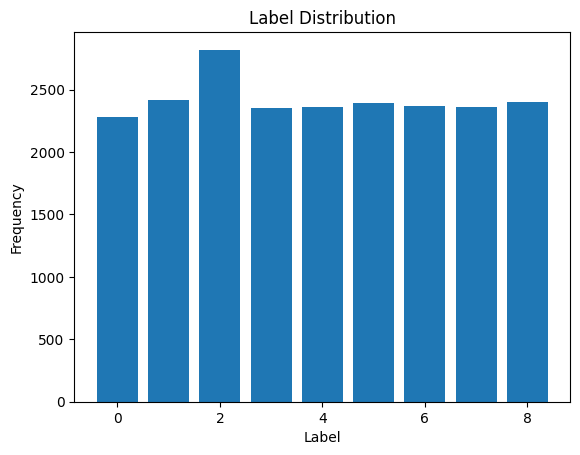

In [17]:
feature_plotting.check_label_distribution(vectors)

### Setup

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [14]:
from mlp_single_layer import MalwaresModelLinearLayer
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 2.8 K 
------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   7,   0,   0,   0,   0,  91,   0],
        [  0,   0,  20,   0,   0,   7,   0,  96,   0],
        [  0,   0,   1,   0,   0,   0,   0, 132,   0],
        [  0,   0,  12,   0,   0,   0,   0,  83,   0],
        [  0,   0,   2,   0,   0,   0,   0, 111,   0],
        [  0,   0,   0,   0,   0,   0,   0, 118,   0],
        [  0,   0,   2,   0,   0,   0,   0,  99,   0],
        [ 14,   0,   0,   0,   0,  21,   0,  74,   0],
        [  0,   0,   0,   0,   0,   1,   0, 106,   3]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 435,   26,  343,  450,  620,   18,  350,  141,    0],
        [   0, 2357,   28,    0,    0,   11,    0,  147,    0],
        [  82,   87, 1626,  168,  337,  250,  215,  188,    0],
        [ 315,   23,  435,  639,  556,   16,  337,  129,    0],
        [  89,   35,  266,  383, 1354,   19,  184,  148,    0],
        [   0,  108,  161,    0,    3, 2056,    0,  180,    0],
        [  86,   56,  982,  203,  396,  162,  425,  161,    0],
        [  27,   79,    0,    0,    0,   27,    0, 2336,    0],
        [   0,   13,    2,   10,    0,   12,    8,  169, 2296]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 435,   26,  343,  450,  620,   18,  350,  141,    0],
        [   0, 2357,   28,    0,    0,   11,    0,  147,    0],
        [  82,   87, 1626,  168,  337,  250,  215,  188,    0],
        [ 315,   23,  435,  639,  556,   16,  337,  129,    0],
        [  89,   35,  266,  383, 1354,   19,  184,  148,   

Metric Validation/Accuracy improved. New best score: 0.673


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[1598,   26,  403,  964,  871,   18,  647,  141,    0],
        [   0, 4777,   28,    0,    0,   11,    0,  147,    0],
        [ 217,   98, 3679,  293,  619,  319,  360,  188,    0],
        [ 915,   23,  637, 1692,  781,   16,  612,  129,    0],
        [ 238,   35,  352,  482, 3132,   24,  432,  148,    0],
        [   0,  108,  175,    0,    3, 4432,    0,  180,    0],
        [ 293,   56, 1923,  411,  692,  214, 1091,  161,    0],
        [  27,   79,    0,    0,    0,   27,    0, 4696,    0],
        [   0,   13,    2,   10,    0,   12,    8,  169, 4696]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[1598,   26,  403,  964,  871,   18,  647,  141,    0],
        [   0, 4777,   28,    0,    0,   11,    0,  147,    0],
        [ 217,   98, 3679,  293,  619,  319,  360,  188,    0],
        [ 915,   23,  637, 1692,  781,   16,  612,  129,    0],
        [ 238,   35,  352,  482, 3132,   24,  432,  148,   

Metric Validation/Accuracy improved by 0.109 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[3076,   26,  426, 1524,  916,   18,  826,  141,    0],
        [   0, 7197,   28,    0,    0,   11,    0,  147,    0],
        [ 319,   98, 5903,  422,  733,  353,  577,  188,    0],
        [1420,   23,  750, 3147,  848,   16,  827,  129,    0],
        [ 314,   35,  399,  588, 5098,   32,  594,  148,    0],
        [   0,  108,  196,    0,    3, 6801,    0,  180,    0],
        [ 475,   56, 2745,  680,  875,  243, 1976,  161,    0],
        [  27,   79,    0,    0,    0,   27,    0, 7056,    0],
        [   0,   13,    2,   10,    0,   12,    8,  169, 7096]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[3076,   26,  426, 1524,  916,   18,  826,  141,    0],
        [   0, 7197,   28,    0,    0,   11,    0,  147,    0],
        [ 319,   98, 5903,  422,  733,  353,  577,  188,    0],
        [1420,   23,  750, 3147,  848,   16,  827,  129,    0],
        [ 314,   35,  399,  588, 5098,   32,  594,  148,   

Metric Validation/Accuracy improved by 0.046 >= min_delta = 0.0. New best score: 0.827


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[4634,   26,  434, 2105,  925,   18,  955,  141,    0],
        [   0, 9617,   28,    0,    0,   11,    0,  147,    0],
        [ 427,   98, 8180,  539,  768,  379,  834,  188,    0],
        [1921,   23,  823, 4719,  869,   16, 1015,  129,    0],
        [ 386,   35,  412,  687, 7198,   42,  665,  148,    0],
        [   0,  108,  214,    0,    3, 9173,    0,  180,    0],
        [ 678,   56, 3566, 1009,  963,  267, 2881,  161,    0],
        [  27,   79,    0,    0,    0,   27,    0, 9416,    0],
        [   0,   13,    2,   10,    0,   12,    8,  169, 9496]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.827


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[4634,   26,  434, 2105,  925,   18,  955,  141,    0],
        [   0, 9617,   28,    0,    0,   11,    0,  147,    0],
        [ 427,   98, 8180,  539,  768,  379,  834,  188,    0],
        [1921,   23,  823, 4719,  869,   16, 1015,  129,    0],
        [ 386,   35,  412,  687, 7198,   42,  665,  148,    0],
        [   0,  108,  214,    0,    3, 9173,    0,  180,    0],
        [ 678,   56, 3566, 1009,  963,  267, 2881,  161,    0],
        [  27,   79,    0,    0,    0,   27,    0, 9416,    0],
        [   0,   13,    2,   10,    0,   12,    8,  169, 9496]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 6427,    26,   439,  2493,   930,    18,  1049,   141,     0],
        [    0, 12037,    28,     0,     0,    11,     0,   147,     0],
        [  511,    98, 10458,   638,   794,   403,  1143,   188,     0],
        [ 2464,    23,   897,  6269,   874,    16,  1198,   129,     0],
        [  443,    35,   422,   734,  9398,    51,   707,   148,     0],
        [    0,   108,   228,     0,     3, 11549,     0,   180,     0],
        [  868,    56,  4292,  1278,  1017,   285,  3994,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 11776,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 11896]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 6427,    26,   439,  2493,   930,    18,  1049,   141,     0],
        [    0, 12037,    28,     0,     0,    11,     0,   147,     0],
        [  511,    98, 10458,   638,   794,   403,  1143,   188,     0],
        [ 2464,

Metric Validation/Accuracy improved by 0.032 >= min_delta = 0.0. New best score: 0.859


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 8119,    26,   446,  2994,   932,    18,  1132,   141,     0],
        [    0, 14457,    28,     0,     0,    11,     0,   147,     0],
        [  580,    98, 12775,   741,   812,   426,  1433,   188,     0],
        [ 2906,    23,   951,  7959,   876,    16,  1365,   129,     0],
        [  472,    35,   423,   794, 11643,    56,   732,   148,     0],
        [    0,   108,   235,     0,     3, 13932,     0,   180,     0],
        [ 1024,    56,  5021,  1577,  1043,   301,  5138,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 14136,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 14296]])
Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 8119,    26,   446,  2994,   932,    18,  1132,   141,     0],
        [    0, 14457,    28,     0,     0,    11,     0,   147,     0],
        [  580,    98, 12775,   741,   812,   426,  1433,   188,     0],
        [ 2906,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 9824,    26,   452,  3482,   933,    18,  1217,   141,     0],
        [    0, 16877,    28,     0,     0,    11,     0,   147,     0],
        [  632,    98, 15020,   829,   819,   450,  1837,   188,     0],
        [ 3325,    23,   980,  9703,   876,    16,  1528,   129,     0],
        [  496,    35,   423,   853, 13887,    61,   765,   148,     0],
        [    0,   108,   240,     0,     3, 16317,     0,   180,     0],
        [ 1173,    56,  5614,  1863,  1059,   317,  6448,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 16496,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 16696]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.867


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 9824,    26,   452,  3482,   933,    18,  1217,   141,     0],
        [    0, 16877,    28,     0,     0,    11,     0,   147,     0],
        [  632,    98, 15020,   829,   819,   450,  1837,   188,     0],
        [ 3325,    23,   980,  9703,   876,    16,  1528,   129,     0],
        [  496,    35,   423,   853, 13887,    61,   765,   148,     0],
        [    0,   108,   240,     0,     3, 16317,     0,   180,     0],
        [ 1173,    56,  5614,  1863,  1059,   317,  6448,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 16496,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 16696]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[11745,    26,   457,  3780,   933,    18,  1278,   141,     0],
        [    0, 19297,    28,     0,     0,    11,     0,   147,     0],
        [  696,    98, 17371,   891,   825,   468,  2156,   188,     0],
        [ 3765,    23,  1024, 11432,   876,    16,  1670,   129,     0],
        [  521,    35,   423,   883, 16185,    66,   772,   148,     0],
        [    0,   108,   244,     0,     3, 18703,     0,   180,     0],
        [ 1340,    56,  6282,  2121,  1078,   333,  7690,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 18856,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 19096]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[11745,    26,   457,  3780,   933,    18,  1278,   141,     0],
        [    0, 19297,    28,     0,     0,    11,     0,   147,     0],
        [  696,    98, 17371,   891,   825,   468,  2156,   188,     0],
        [ 3765,

Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[13686,    26,   464,  4057,   933,    18,  1338,   141,     0],
        [    0, 21717,    28,     0,     0,    11,     0,   147,     0],
        [  724,    98, 19748,   951,   829,   483,  2492,   188,     0],
        [ 4212,    23,  1066, 13157,   876,    16,  1811,   129,     0],
        [  536,    35,   423,   903, 18505,    71,   777,   148,     0],
        [    0,   108,   248,     0,     3, 21089,     0,   180,     0],
        [ 1482,    56,  6912,  2391,  1091,   351,  8987,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 21216,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 21496]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[13686,    26,   464,  4057,   933,    18,  1338,   141,     0],
        [    0, 21717,    28,     0,     0,    11,     0,   147,     0],
        [  724,    98, 19748,   951,   829,   483,  2492,   188,     0],
        [ 4212,

Metric Validation/Accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.887


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[15658,    26,   470,  4309,   933,    18,  1393,   141,     0],
        [    0, 24137,    28,     0,     0,    11,     0,   147,     0],
        [  751,    98, 22115,  1000,   829,   495,  2857,   188,     0],
        [ 4638,    23,  1089, 14929,   876,    16,  1945,   129,     0],
        [  545,    35,   423,   929, 20826,    76,   781,   148,     0],
        [    0,   108,   253,     0,     3, 23474,     0,   180,     0],
        [ 1635,    56,  7481,  2638,  1100,   366, 10364,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 23576,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 23896]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[15658,    26,   470,  4309,   933,    18,  1393,   141,     0],
        [    0, 24137,    28,     0,     0,    11,     0,   147,     0],
        [  751,    98, 22115,  1000,   829,   495,  2857,   188,     0],
        [ 4638

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[17680,    26,   475,  4531,   933,    18,  1429,   141,     0],
        [    0, 26557,    28,     0,     0,    11,     0,   147,     0],
        [  778,    98, 24501,  1050,   829,   507,  3202,   188,     0],
        [ 5025,    23,  1109, 16753,   876,    16,  2069,   129,     0],
        [  565,    35,   423,   946, 23149,    81,   781,   148,     0],
        [    0,   108,   254,     0,     3, 25863,     0,   180,     0],
        [ 1777,    56,  8065,  2875,  1108,   381, 11748,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 25936,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 26296]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[17680,    26,   475,  4531,   933,    18,  1429,   141,     0],
        [    0, 26557,    28,     0,     0,    11,     0,   147,     0],
        [  778,    98, 24501,  1050,   829,   507,  3202,   188,     0],
        [ 502

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.896


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[19705,    26,   482,  4746,   933,    18,  1467,   141,     0],
        [    0, 28977,    28,     0,     0,    11,     0,   147,     0],
        [  788,    98, 26924,  1087,   829,   518,  3541,   188,     0],
        [ 5356,    23,  1124, 18634,   876,    16,  2197,   129,     0],
        [  582,    35,   423,   958, 25480,    86,   781,   148,     0],
        [    0,   108,   257,     0,     3, 28250,     0,   180,     0],
        [ 1893,    56,  8642,  3124,  1116,   396, 13153,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 28296,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 28696]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[19705,    26,   482,  4746,   933,    18,  1467,   141,     0],
        [    0, 28977,    28,     0,     0,    11,     0,   147,     0],
        [  788,    98, 26924,  1087,   829,   518,  3541,   188,     0],
        [ 535

Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[21667,    26,   487,  5031,   933,    18,  1500,   141,     0],
        [    0, 31397,    28,     0,     0,    11,     0,   147,     0],
        [  795,    98, 29361,  1126,   829,   525,  3871,   188,     0],
        [ 5667,    23,  1142, 20559,   876,    16,  2298,   129,     0],
        [  594,    35,   423,   974, 27812,    91,   781,   148,     0],
        [    0,   108,   260,     0,     3, 30637,     0,   180,     0],
        [ 2006,    56,  9207,  3378,  1122,   408, 14573,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 30656,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 31096]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[21667,    26,   487,  5031,   933,    18,  1500,   141,     0],
        [    0, 31397,    28,     0,     0,    11,     0,   147,     0],
        [  795,    98, 29361,  1126,   829,   525,  3871,   188,     0],
        [ 566

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[23666,    26,   489,  5269,   933,    18,  1546,   141,     0],
        [    0, 33817,    28,     0,     0,    11,     0,   147,     0],
        [  803,    98, 31685,  1160,   829,   537,  4313,   188,     0],
        [ 5957,    23,  1154, 22484,   876,    16,  2426,   129,     0],
        [  601,    35,   423,   986, 30153,    96,   781,   148,     0],
        [    0,   108,   260,     0,     3, 33027,     0,   180,     0],
        [ 2134,    56,  9674,  3601,  1127,   419, 16109,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 33016,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 33496]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[23666,    26,   489,  5269,   933,    18,  1546,   141,     0],
        [    0, 33817,    28,     0,     0,    11,     0,   147,     0],
        [  803,    98, 31685,  1160,   829,   537,  4313,   188,     0],
        [ 595

Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[25740,    26,   491,  5439,   933,    18,  1585,   141,     0],
        [    0, 36237,    28,     0,     0,    11,     0,   147,     0],
        [  808,    98, 34075,  1188,   829,   541,  4706,   188,     0],
        [ 6226,    23,  1166, 24443,   876,    16,  2541,   129,     0],
        [  603,    35,   423,  1000, 32499,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 35416,     0,   180,     0],
        [ 2246,    56, 10124,  3841,  1130,   428, 17665,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 35376,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 35896]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[25740,    26,   491,  5439,   933,    18,  1585,   141,     0],
        [    0, 36237,    28,     0,     0,    11,     0,   147,     0],
        [  808,    98, 34075,  1188,   829,   541,  4706,   188,     0],
        [ 622

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.924


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[27862,    26,   495,  5574,   933,    18,  1609,   141,     0],
        [    0, 38657,    28,     0,     0,    11,     0,   147,     0],
        [  813,    98, 36513,  1210,   829,   545,  5057,   188,     0],
        [ 6534,    23,  1178, 26373,   876,    16,  2646,   129,     0],
        [  607,    35,   423,  1011, 34849,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 37806,     0,   180,     0],
        [ 2371,    56, 10649,  4076,  1134,   437, 19137,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 37736,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 38296]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[27862,    26,   495,  5574,   933,    18,  1609,   141,     0],
        [    0, 38657,    28,     0,     0,    11,     0,   147,     0],
        [  813,    98, 36513,  1210,   829,   545,  5057,   188,     0],
        [ 653

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[29997,    26,   497,  5695,   933,    18,  1636,   141,     0],
        [    0, 41077,    28,     0,     0,    11,     0,   147,     0],
        [  817,    98, 38954,  1230,   829,   547,  5410,   188,     0],
        [ 6886,    23,  1186, 28248,   876,    16,  2766,   129,     0],
        [  613,    35,   423,  1017, 37202,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 40196,     0,   180,     0],
        [ 2480,    56, 11098,  4303,  1135,   444, 20714,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 40096,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 40696]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[29997,    26,   497,  5695,   933,    18,  1636,   141,     0],
        [    0, 41077,    28,     0,     0,    11,     0,   147,     0],
        [  817,    98, 38954,  1230,   829,   547,  5410,   188,     0],
        [ 688

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[32123,    26,   499,  5820,   933,    18,  1668,   141,     0],
        [    0, 43497,    28,     0,     0,    11,     0,   147,     0],
        [  825,    98, 41443,  1247,   829,   547,  5716,   188,     0],
        [ 7276,    23,  1195, 30108,   876,    16,  2862,   129,     0],
        [  619,    35,   423,  1021, 39557,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 42586,     0,   180,     0],
        [ 2611,    56, 11599,  4508,  1138,   453, 22235,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 42456,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 43096]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[32123,    26,   499,  5820,   933,    18,  1668,   141,     0],
        [    0, 43497,    28,     0,     0,    11,     0,   147,     0],
        [  825,    98, 41443,  1247,   829,   547,  5716,   188,     0],
        [ 727

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[34291,    26,   501,  5909,   933,    18,  1694,   141,     0],
        [    0, 45917,    28,     0,     0,    11,     0,   147,     0],
        [  825,    98, 43909,  1258,   829,   549,  6057,   188,     0],
        [ 7494,    23,  1206, 32152,   876,    16,  2944,   129,     0],
        [  623,    35,   423,  1025, 41914,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 44976,     0,   180,     0],
        [ 2706,    56, 12015,  4740,  1141,   462, 23850,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 44816,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 45496]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.935


Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[34291,    26,   501,  5909,   933,    18,  1694,   141,     0],
        [    0, 45917,    28,     0,     0,    11,     0,   147,     0],
        [  825,    98, 43909,  1258,   829,   549,  6057,   188,     0],
        [ 7494,    23,  1206, 32152,   876,    16,  2944,   129,     0],
        [  623,    35,   423,  1025, 41914,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 44976,     0,   180,     0],
        [ 2706,    56, 12015,  4740,  1141,   462, 23850,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 44816,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 45496]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[36459,    26,   501,  6001,   933,    18,  1719,   141,     0],
        [    0, 48337,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 46406,  1266,   829,   549,  6371,   188,     0],
        [ 7715,    23,  1215, 34198,   876,    16,  3023,   129,     0],
        [  624,    35,   423,  1027, 44276,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 47366,     0,   180,     0],
        [ 2808,    56, 12477,  4960,  1144,   466, 25429,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 47176,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 47896]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[36459,    26,   501,  6001,   933,    18,  1719,   141,     0],
        [    0, 48337,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 46406,  1266,   829,   549,  6371,   188,     0],
        [ 771

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[38624,    26,   501,  6099,   933,    18,  1741,   141,     0],
        [    0, 50757,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 48912,  1273,   829,   549,  6678,   188,     0],
        [ 7901,    23,  1228, 36285,   876,    16,  3092,   129,     0],
        [  625,    35,   423,  1030, 46637,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 49756,     0,   180,     0],
        [ 2898,    56, 12930,  5198,  1146,   471, 27011,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 49536,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 50296]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[38624,    26,   501,  6099,   933,    18,  1741,   141,     0],
        [    0, 50757,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 48912,  1273,   829,   549,  6678,   188,     0],
        [ 790

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[40822,    26,   502,  6168,   933,    18,  1758,   141,     0],
        [    0, 53177,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 51375,  1280,   829,   549,  7028,   188,     0],
        [ 8150,    23,  1237, 38289,   876,    16,  3185,   129,     0],
        [  625,    35,   423,  1032, 49000,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 52146,     0,   180,     0],
        [ 2981,    56, 13321,  5413,  1146,   473, 28690,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 51896,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 52696]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[40822,    26,   502,  6168,   933,    18,  1758,   141,     0],
        [    0, 53177,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 51375,  1280,   829,   549,  7028,   188,     0],
        [ 815

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[43025,    26,   502,  6233,   933,    18,  1775,   141,     0],
        [    0, 55597,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 53883,  1288,   829,   549,  7332,   188,     0],
        [ 8348,    23,  1247, 40372,   876,    16,  3249,   129,     0],
        [  627,    35,   423,  1035, 51360,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 54536,     0,   180,     0],
        [ 3070,    56, 13736,  5636,  1146,   475, 30331,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 54256,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 55096]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[43025,    26,   502,  6233,   933,    18,  1775,   141,     0],
        [    0, 55597,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 53883,  1288,   829,   549,  7332,   188,     0],
        [ 834

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[45227,    26,   502,  6300,   933,    18,  1791,   141,     0],
        [    0, 58017,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 56395,  1292,   829,   549,  7636,   188,     0],
        [ 8540,    23,  1257, 42465,   876,    16,  3309,   129,     0],
        [  629,    35,   423,  1036, 53722,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 56926,     0,   180,     0],
        [ 3158,    56, 14132,  5860,  1146,   476, 31992,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 56616,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 57496]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[45227,    26,   502,  6300,   933,    18,  1791,   141,     0],
        [    0, 58017,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 56395,  1292,   829,   549,  7636,   188,     0],
        [ 854

Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[47369,    26,   503,  6423,   933,    18,  1810,   141,     0],
        [    0, 60437,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 58926,  1300,   829,   549,  7917,   188,     0],
        [ 8710,    23,  1264, 44573,   876,    16,  3379,   129,     0],
        [  629,    35,   423,  1039, 56084,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 59316,     0,   180,     0],
        [ 3233,    56, 14561,  6108,  1146,   477, 33609,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 58976,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 59896]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[47369,    26,   503,  6423,   933,    18,  1810,   141,     0],
        [    0, 60437,    28,     0,     0,    11,     0,   147,     0],
        [  826,    98, 58926,  1300,   829,   549,  7917,   188,     0],
        [ 871

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[49586,    26,   504,  6469,   933,    18,  1831,   141,     0],
        [    0, 62857,    28,     0,     0,    11,     0,   147,     0],
        [  828,    98, 61414,  1305,   829,   549,  8242,   188,     0],
        [ 8879,    23,  1274, 46674,   876,    16,  3454,   129,     0],
        [  629,    35,   423,  1040, 58448,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 61706,     0,   180,     0],
        [ 3314,    56, 14934,  6330,  1146,   478, 35302,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 61336,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 62296]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[49586,    26,   504,  6469,   933,    18,  1831,   141,     0],
        [    0, 62857,    28,     0,     0,    11,     0,   147,     0],
        [  828,    98, 61414,  1305,   829,   549,  8242,   188,     0],
        [ 887

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[51789,    26,   504,  6533,   933,    18,  1849,   141,     0],
        [    0, 65277,    28,     0,     0,    11,     0,   147,     0],
        [  830,    98, 63901,  1306,   829,   549,  8572,   188,     0],
        [ 9059,    23,  1282, 48775,   876,    16,  3520,   129,     0],
        [  629,    35,   423,  1040, 60813,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 64096,     0,   180,     0],
        [ 3400,    56, 15267,  6539,  1146,   478, 37044,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 63696,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 64696]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[51789,    26,   504,  6533,   933,    18,  1849,   141,     0],
        [    0, 65277,    28,     0,     0,    11,     0,   147,     0],
        [  830,    98, 63901,  1306,   829,   549,  8572,   188,     0],
        [ 905

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[53972,    26,   504,  6619,   933,    18,  1865,   141,     0],
        [    0, 67697,    28,     0,     0,    11,     0,   147,     0],
        [  830,    98, 66407,  1309,   829,   549,  8883,   188,     0],
        [ 9207,    23,  1290, 50911,   876,    16,  3583,   129,     0],
        [  629,    35,   423,  1041, 63177,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 66486,     0,   180,     0],
        [ 3466,    56, 15610,  6751,  1146,   478, 38793,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 66056,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 67096]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[53972,    26,   504,  6619,   933,    18,  1865,   141,     0],
        [    0, 67697,    28,     0,     0,    11,     0,   147,     0],
        [  830,    98, 66407,  1309,   829,   549,  8883,   188,     0],
        [ 920

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[56192,    26,   504,  6668,   933,    18,  1881,   141,     0],
        [    0, 70117,    28,     0,     0,    11,     0,   147,     0],
        [  830,    98, 68965,  1310,   829,   549,  9144,   188,     0],
        [ 9401,    23,  1300, 52997,   876,    16,  3648,   129,     0],
        [  629,    35,   423,  1041, 65542,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 68876,     0,   180,     0],
        [ 3541,    56, 16017,  6958,  1146,   481, 40471,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 68416,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 69496]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[56192,    26,   504,  6668,   933,    18,  1881,   141,     0],
        [    0, 70117,    28,     0,     0,    11,     0,   147,     0],
        [  830,    98, 68965,  1310,   829,   549,  9144,   188,     0],
        [ 940

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[58425,    26,   505,  6705,   933,    18,  1895,   141,     0],
        [    0, 72537,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 71513,  1316,   829,   549,  9409,   188,     0],
        [ 9548,    23,  1308, 55144,   876,    16,  3701,   129,     0],
        [  629,    35,   423,  1041, 67907,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 71266,     0,   180,     0],
        [ 3620,    56, 16404,  7176,  1146,   481, 42157,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 70776,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 71896]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[58425,    26,   505,  6705,   933,    18,  1895,   141,     0],
        [    0, 72537,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 71513,  1316,   829,   549,  9409,   188,     0],
        [ 954

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[60661,    26,   505,  6738,   933,    18,  1911,   141,     0],
        [    0, 74957,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 74075,  1324,   829,   549,  9659,   188,     0],
        [ 9659,    23,  1313, 57334,   876,    16,  3750,   129,     0],
        [  629,    35,   423,  1041, 70272,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 73656,     0,   180,     0],
        [ 3687,    56, 16801,  7398,  1146,   483, 43839,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 73136,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 74296]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[60661,    26,   505,  6738,   933,    18,  1911,   141,     0],
        [    0, 74957,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 74075,  1324,   829,   549,  9659,   188,     0],
        [ 965

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[62903,    26,   505,  6766,   933,    18,  1926,   141,     0],
        [    0, 77377,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 76636,  1325,   829,   549,  9917,   188,     0],
        [ 9796,    23,  1322, 59481,   876,    16,  3812,   129,     0],
        [  629,    35,   423,  1041, 72637,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 76046,     0,   180,     0],
        [ 3759,    56, 17166,  7604,  1146,   484, 45565,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 75496,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 76696]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[62903,    26,   505,  6766,   933,    18,  1926,   141,     0],
        [    0, 77377,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 76636,  1325,   829,   549,  9917,   188,     0],
        [ 979

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[65134,    26,   505,  6805,   933,    18,  1941,   141,     0],
        [    0, 79797,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 79193,  1327,   829,   549, 10178,   188,     0],
        [ 9943,    23,  1328, 61629,   876,    16,  3866,   129,     0],
        [  629,    35,   423,  1041, 75002,    99,   781,   148,     0],
        [    0,   108,   261,     0,     3, 78436,     0,   180,     0],
        [ 3822,    56, 17496,  7816,  1146,   486, 47328,   161,     0],
        [   27,    79,     0,     0,     0,    27,     0, 77856,     0],
        [    0,    13,     2,    10,     0,    12,     8,   169, 79096]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[65134,    26,   505,  6805,   933,    18,  1941,   141,     0],
        [    0, 79797,    28,     0,     0,    11,     0,   147,     0],
        [  831,    98, 79193,  1327,   829,   549, 10178,   188,     0],
        [ 994

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.952. Signaling Trainer to stop.


In [16]:
model.eval()

MalwaresModelLinearLayer(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=305, out_features=9, bias=True)
)

In [17]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/old_logs/single-layer_300_30s/version_0/checkpoints/epoch=27-step=980.ckpt
tensor(0.9524, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[455,   0,   0,  14,   0,   0,   3,   0,   0],
        [  0, 479,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 489,   0,   0,   0,  72,   0,   0],
        [ 15,   0,   1, 447,   0,   0,  13,   0,   0],
        [  0,   0,   0,   0, 459,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 501,   0,   0,   0],
        [  8,   0,  50,  37,   0,   0, 371,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 474,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 465]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9523912668228149
      Test/F1Score          0.9515997171401978
        Test/Loss           0.23852555453777313
     Test/Precision         0

[{'Test/Loss': 0.23852555453777313,
  'Test/Accuracy': 0.9523912668228149,
  'Test/Precision': 0.9518693685531616,
  'Test/Recall': 0.9523912668228149,
  'Test/F1Score': 0.9515997171401978,
  'TestEpoch/Accuracy': 0.9523170590400696,
  'TestEpoch/Precision': 0.9514786005020142,
  'TestEpoch/Recall': 0.9523170590400696,
  'TestEpoch/F1Score': 0.951800525188446}]

In [18]:
# Extract the weights from the linear layer
weights = best_model.l1.weight.data

# Convert to numpy array for easier manipulation
weights_np = weights.numpy()

# Calculate the absolute values of the weights
abs_weights = abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Print the top features
print("Feature importance based on weights:")
for i, feature_idx in enumerate(top_features[0]):
    feature_name = df.columns[feature_idx]
    print(f"Rank {i+1}: Feature {feature_idx}{feature_name} with weight {weights_np[0][feature_idx]}")


Feature importance based on weights:
Rank 1: Feature 12writeback:writeback_dirty_inode_start with weight 0.0456441193819046
Rank 2: Feature 131timer:timer_cancel with weight -0.009365249425172806
Rank 3: Feature 228getsockopt with weight -0.2979276478290558
Rank 4: Feature 3writeback:writeback_dirty_inode_FLS_data with weight 0.01916448026895523
Rank 5: Feature 194tcp:tcp_probe_RES_data with weight 0.4069821834564209
Rank 6: Feature 82sched:sched_process_wait with weight -0.52554851770401
Rank 7: Feature 285ioctl with weight 0.5016101002693176
Rank 8: Feature 303readlink with weight -1.5149829387664795
Rank 9: Feature 188writeback:global_dirty_state_RES_data with weight -0.08187131583690643
Rank 10: Feature 205exit_group with weight -0.3949398696422577
Rank 11: Feature 111cache-misses with weight -1.1937795877456665
Rank 12: Feature 152cpu-cycles with weight 0.44854554533958435
Rank 13: Feature 65timer:timer_start_KERN_data with weight -0.2362551987171173
Rank 14: Feature 125branch-ins

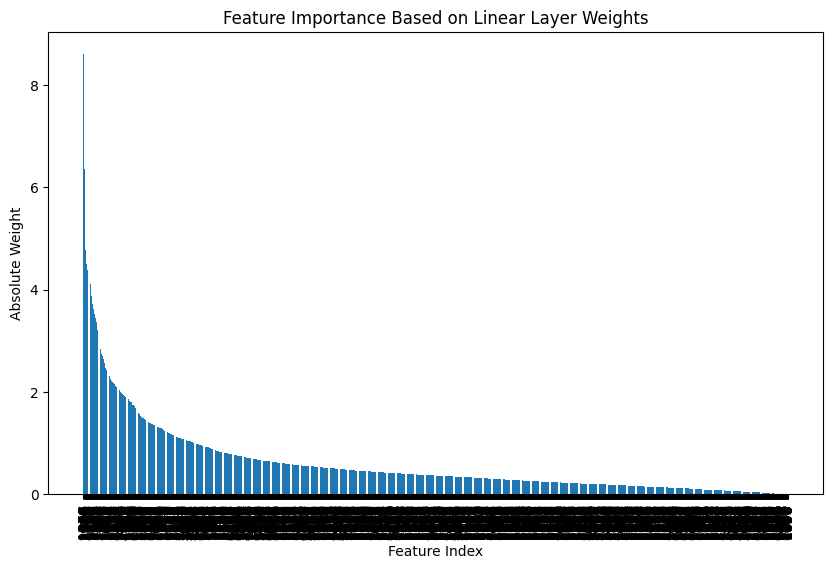

In [19]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
weights_np = weights.numpy().flatten()  # Flatten to 1D array

# Calculate the absolute values of the weights
abs_weights = np.abs(weights_np)

# Get the indices of the top features based on weight magnitude
top_features = abs_weights.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_np)), abs_weights[top_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
plt.xticks(range(len(weights_np)), top_features, rotation=90)
plt.show()

In [20]:
weights = best_model.l1.weight.data.numpy()
abs_weights = np.abs(weights.flatten())

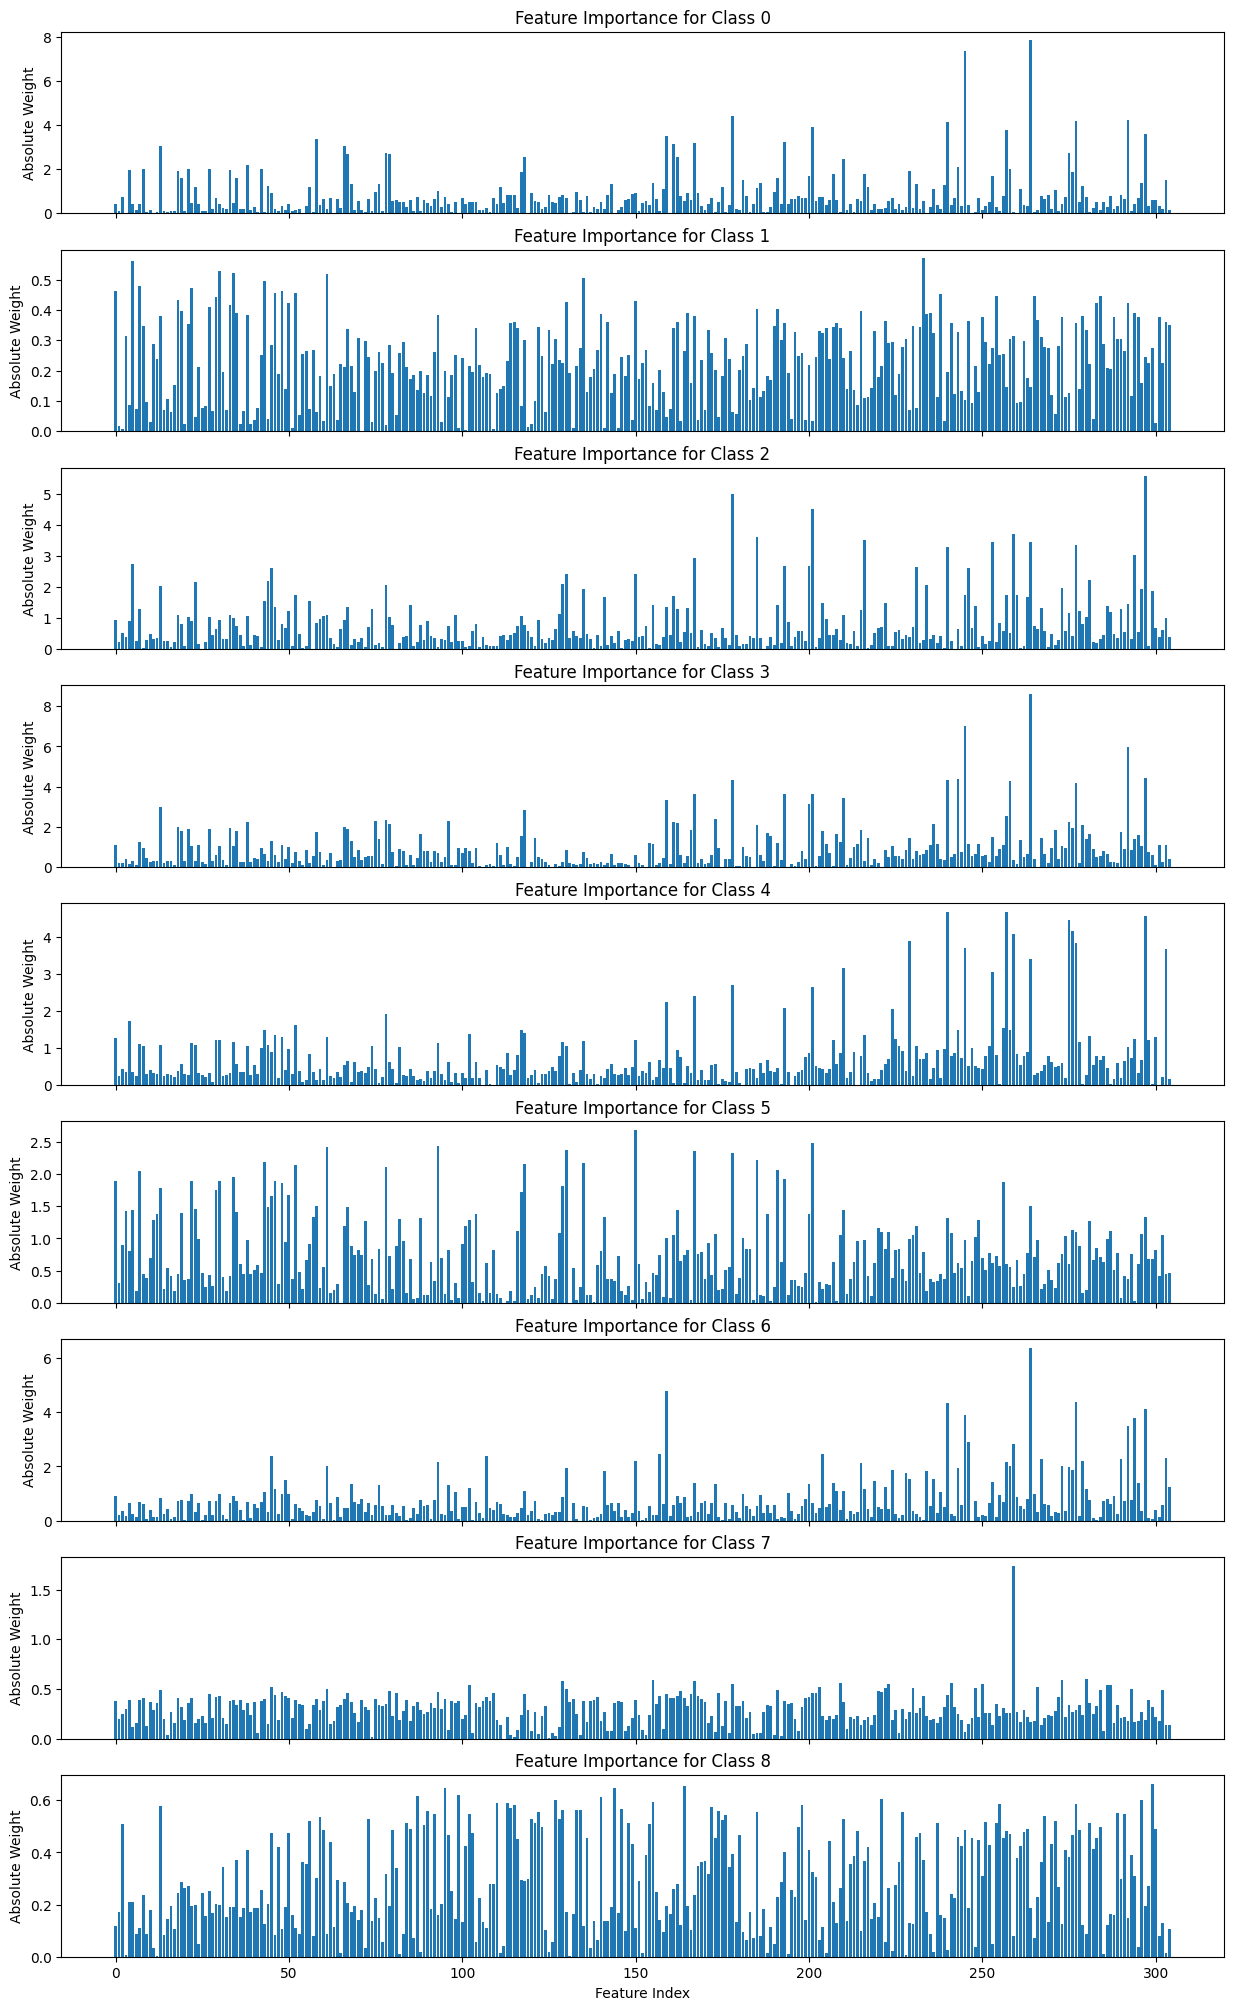

In [21]:
nrows = weights.shape[0]
xrows = weights.shape[1]

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 25), sharex=True)

for i in range(nrows):
    axes[i].bar(range(xrows), abs_weights[i*xrows:(i+1)*xrows])
    axes[i].set_title(f'Feature Importance for Class {i}')
    axes[i].set_ylabel('Absolute Weight')

plt.xlabel('Feature Index')
plt.show()

### Plotting Mean over Classes

In [22]:
from sklearn.preprocessing import minmax_scale

scaled_weights = minmax_scale(weights, axis=0)
weights_mean = np.abs(scaled_weights).mean(axis=0)

In [23]:
sorted_idx = weights_mean.argsort()[::-1]

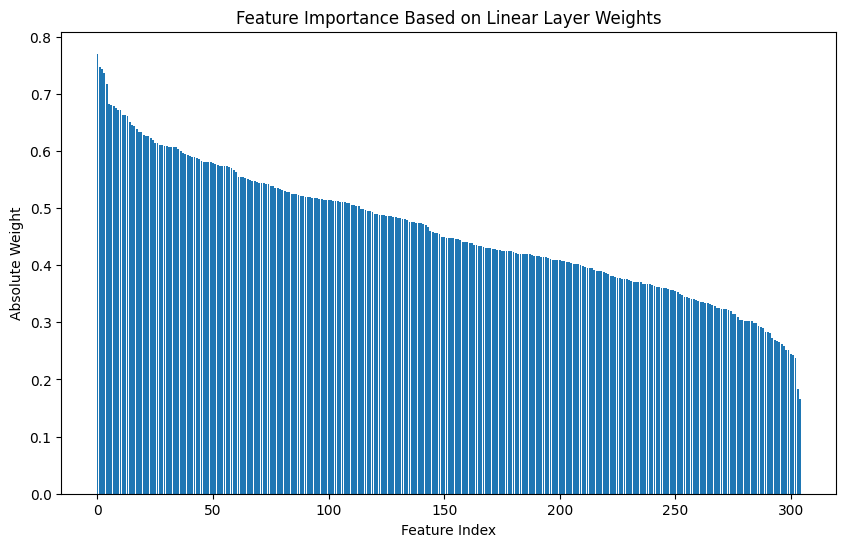

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx])), weights_mean[sorted_idx])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx, sorted_idx, rotation=90)
plt.show()

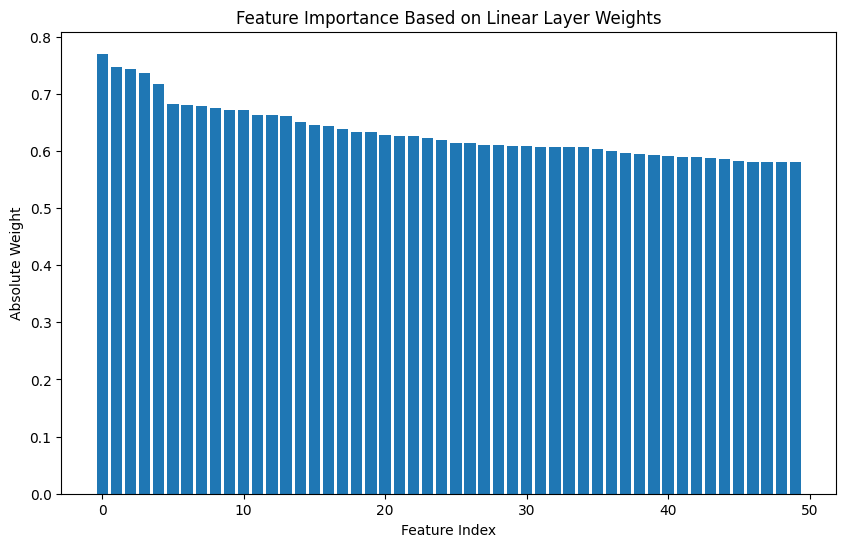

In [25]:
top_k = 50

plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[sorted_idx[:top_k]])), weights_mean[sorted_idx[:top_k]])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Plotting top k per class

In [26]:
topk = 4

In [27]:
topk_indices = weights.argpartition( -topk, axis=1)[:, -topk:]
topk_indices.shape

(9, 4)

In [28]:
topk_indices_sorted = np.take_along_axis(topk_indices, np.argsort(-weights[np.arange(weights.shape[0])[:, None], topk_indices]), axis=1)
topk_indices_sorted.shape

(9, 4)

In [29]:
selected_features = np.array(list(set(topk_indices_sorted.flatten())))
selected_features.shape

(32,)

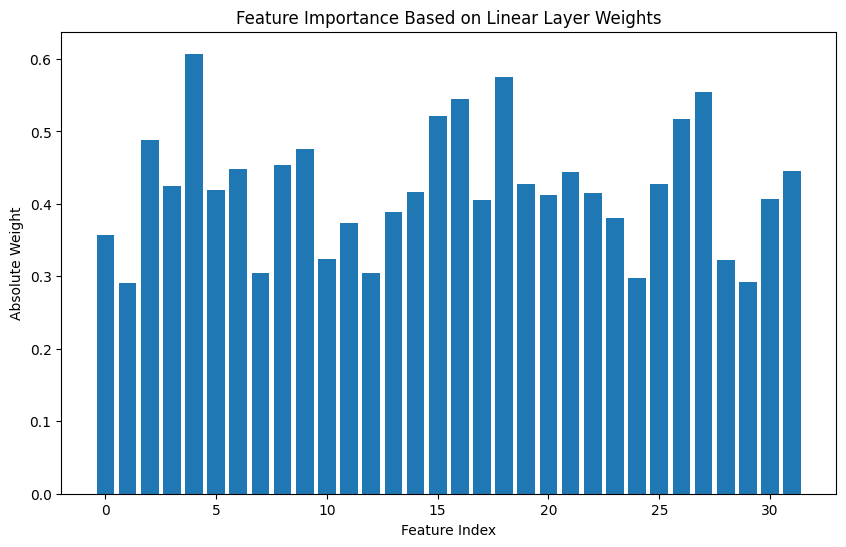

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights_mean[selected_features])), weights_mean[selected_features])
plt.xlabel('Feature Index')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance Based on Linear Layer Weights')
# plt.xticks(sorted_idx[:20], sorted_idx[:20], rotation=90)
plt.show()

### Train again

In [31]:
vectors.iloc[:,selected_features].shape

(21765, 32)

In [32]:
subset = vectors.iloc[:,selected_features]
subset["label"] = df["label"]

/tmp/ipykernel_211628/650136668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["label"] = df["label"]


In [33]:
# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_2)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelLinearLayer(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 297   
------------------------------------------------------------
297       Trainable params
0         Non-trainable params
297       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,  90,   4,   0,   4,   0,   0,   0,   0],
        [ 54,   0,   0,   0,  69,   0,   0,   0,   0],
        [  0, 128,   0,   0,   5,   0,   0,   0,   0],
        [  0,  91,   2,   0,   2,   0,   0,   0,   0],
        [  0, 107,   5,   0,   1,   0,   0,   0,   0],
        [  0,  33,   1,   0,  84,   0,   0,   0,   0],
        [  0,  96,   1,   0,   4,   0,   0,   0,   0],
        [  0,   0,  55,   0,  53,   0,   1,   0,   0],
        [  0, 110,   0,   0,   0,   0,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0, 1204, 1103,    0,   10,   10,    0,    0,   56],
        [ 121, 2217,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1668, 1267,    0,    5,   13,    0,    0,    0],
        [   0, 1205, 1119,    0,    6,    8,    0,    0,  112],
        [   0, 1576,  716,    0,   62,    6,    0,    0,  118],
        [   0, 1611,  162,    0,  143,  583,    0,    9,    0],
        [   0, 1317, 1110,    0,   10,   20,    0,    0,   14],
        [   0,  109,  121,    0,  123,    0,    5, 2111,    0],
        [   0, 1232,    0,    0,    0,    0,    0,    0, 1278]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0, 1204, 1103,    0,   10,   10,    0,    0,   56],
        [ 121, 2217,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1668, 1267,    0,    5,   13,    0,    0,    0],
        [   0, 1205, 1119,    0,    6,    8,    0,    0,  112],
        [   0, 1576,  716,    0,   62,    6,    0,    0,  1

Metric Validation/Accuracy improved. New best score: 0.537


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[   0, 1210, 3308,    0,   10,   44,    0,    0,   96],
        [ 121, 4637,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1683, 4048,    0,    5,   37,    0,    0,    0],
        [   0, 1205, 3358,    0,    6,   33,    0,    0,  203],
        [   0, 1577, 1655,    0, 1435,   27,    0,    0,  149],
        [   0, 1625,  622,    0,  143, 2499,    0,    9,    0],
        [   0, 1317, 3407,    0,   10,   85,    0,    0,   22],
        [   0,  109,  121,    0,  123,    0,    5, 4471,    0],
        [   0, 1232,    0,    0,    0,    0,    0,    0, 3678]])
Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[   0, 1210, 3308,    0,   10,   44,    0,    0,   96],
        [ 121, 4637,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1683, 4048,    0,    5,   37,    0,    0,    0],
        [   0, 1205, 3358,    0,    6,   33,    0,    0,  203],
        [   0, 1577, 1655,    0, 1435,   27,    0,    0,  1

Metric Validation/Accuracy improved by 0.067 >= min_delta = 0.0. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[   9, 1215, 5487,   36,   10,   74,    0,    0,  122],
        [ 121, 7057,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1695, 6832,    0,    5,   61,    0,    0,    0],
        [   0, 1205, 5445,  182,    9,   58,    0,    0,  261],
        [   0, 1577, 2003,    4, 3427,   43,    0,    0,  154],
        [   0, 1627, 1208,    0,  143, 4298,    3,    9,    0],
        [   0, 1317, 5705,    2,   10,  150,    0,    0,   27],
        [   0,  109,  121,    0,  123,    0,    5, 6831,    0],
        [   0, 1232,    0,    0,    0,    0,    0,    0, 6078]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[   9, 1215, 5487,   36,   10,   74,    0,    0,  122],
        [ 121, 7057,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1695, 6832,    0,    5,   61,    0,    0,    0],
        [   0, 1205, 5445,  182,    9,   58,    0,    0,  261],
        [   0, 1577, 2003,    4, 3427,   43,    0,    0,  1

Metric Validation/Accuracy improved by 0.051 >= min_delta = 0.0. New best score: 0.655


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[ 516, 1217, 6852,  371,   34,  108,    1,    0,  139],
        [ 121, 9477,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1707, 9616,    0,    5,   85,    0,    0,    0],
        [   2, 1205, 6668, 1256,   27,   83,    2,    0,  272],
        [   0, 1577, 2199,    4, 5576,   58,    0,    0,  159],
        [   0, 1627, 1593,    0,  143, 6293,   13,    9,    0],
        [   0, 1317, 7959,   43,   10,  215,    5,    0,   32],
        [   0,  109,  121,    0,  123,    0,    5, 9191,    0],
        [   0, 1232,    0,    0,    0,    0,    0,    0, 8478]])
Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[ 516, 1217, 6852,  371,   34,  108,    1,    0,  139],
        [ 121, 9477,    1,    0,  204,    0,    0,    0,    0],
        [   0, 1707, 9616,    0,    5,   85,    0,    0,    0],
        [   2, 1205, 6668, 1256,   27,   83,    2,    0,  272],
        [   0, 1577, 2199,    4, 5576,   58,    0,    0,  1

Metric Validation/Accuracy improved by 0.099 >= min_delta = 0.0. New best score: 0.754


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 2102,  1217,  7235,   642,    40,   137,     1,     0,   149],
        [  121, 11897,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 12400,     0,    13,   109,     0,     0,     0],
        [   15,  1205,  7406,  2818,    34,   108,     7,     0,   277],
        [    0,  1577,  2380,    10,  7734,    73,     0,     0,   164],
        [    0,  1627,  1984,     0,   143,  8282,    23,     9,     0],
        [    0,  1317, 10172,   126,    10,   280,    10,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 11551,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 10878]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 2102,  1217,  7235,   642,    40,   137,     1,     0,   149],
        [  121, 11897,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 12400,     0,    13,   109,     0,     0,     0],
        [   15,

Metric Validation/Accuracy improved by 0.032 >= min_delta = 0.0. New best score: 0.786


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 3919,  1217,  7303,  1014,    46,   154,     1,     0,   154],
        [  121, 14317,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 15184,     0,    25,   133,     0,     0,     0],
        [   54,  1205,  7631,  4858,    49,   133,    18,     0,   277],
        [    0,  1577,  2490,    63,  9920,    88,     0,     0,   165],
        [    0,  1627,  2412,     0,   143, 10234,    33,     9,     0],
        [    0,  1317, 12270,   327,    11,   345,    15,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 13911,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 13278]])


Metric Validation/Accuracy improved by 0.049 >= min_delta = 0.0. New best score: 0.835


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 3919,  1217,  7303,  1014,    46,   154,     1,     0,   154],
        [  121, 14317,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 15184,     0,    25,   133,     0,     0,     0],
        [   54,  1205,  7631,  4858,    49,   133,    18,     0,   277],
        [    0,  1577,  2490,    63,  9920,    88,     0,     0,   165],
        [    0,  1627,  2412,     0,   143, 10234,    33,     9,     0],
        [    0,  1317, 12270,   327,    11,   345,    15,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 13911,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 13278]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 5994,  1217,  7316,  1186,    51,   169,     1,     0,   159],
        [  121, 16737,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 17968,     0,    37,   157,     0,     0,     0],
        [  132,  1205,  7784,  6941,    58,   158,    25,     0,   277],
        [    3,  1577,  2571,   133, 12116,   103,     0,     0,   165],
        [    0,  1627,  2840,     0,   143, 12186,    43,     9,     0],
        [    9,  1317, 14318,   569,    12,   410,    20,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 16271,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 15678]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.843


Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 5994,  1217,  7316,  1186,    51,   169,     1,     0,   159],
        [  121, 16737,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 17968,     0,    37,   157,     0,     0,     0],
        [  132,  1205,  7784,  6941,    58,   158,    25,     0,   277],
        [    3,  1577,  2571,   133, 12116,   103,     0,     0,   165],
        [    0,  1627,  2840,     0,   143, 12186,    43,     9,     0],
        [    9,  1317, 14318,   569,    12,   410,    20,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 16271,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 15678]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[ 8063,  1217,  7321,  1372,    56,   184,     1,     0,   164],
        [  121, 19157,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 20752,     0,    49,   181,     0,     0,     0],
        [  234,  1205,  7825,  9099,    66,   183,    46,     0,   277],
        [    8,  1577,  2619,   240, 14309,   115,     0,     0,   165],
        [    0,  1627,  3162,     0,   143, 14244,    53,     9,     0],
        [   45,  1317, 16154,   946,    16,   475,    72,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 18631,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 18078]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[ 8063,  1217,  7321,  1372,    56,   184,     1,     0,   164],
        [  121, 19157,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 20752,     0,    49,   181,     0,     0,     0],
        [  234,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[10111,  1217,  7328,  1581,    61,   199,     1,     0,   165],
        [  121, 21577,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 23536,     0,    61,   205,     0,     0,     0],
        [  318,  1205,  7878, 11278,    72,   208,    54,     0,   277],
        [   13,  1577,  2673,   352, 16498,   120,     0,     0,   165],
        [    0,  1627,  3557,     0,   143, 16229,    63,     9,     0],
        [   73,  1317, 18035,  1322,    20,   540,    88,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 20991,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 20478]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[10111,  1217,  7328,  1581,    61,   199,     1,     0,   165],
        [  121, 21577,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 23536,     0,    61,   205,     0,     0,     0],
        [  318,

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.845


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[12291,  1217,  7333,  1661,    66,   214,     1,     0,   165],
        [  121, 23997,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 26320,     0,    73,   229,     0,     0,     0],
        [  486,  1205,  7908, 13383,    79,   233,    74,     0,   277],
        [   20,  1577,  2716,   452, 18708,   125,     0,     0,   165],
        [    0,  1627,  3906,     0,   143, 18260,    73,     9,     0],
        [  135,  1317, 19821,  1716,    26,   605,   145,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 23351,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 22878]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[12291,  1217,  7333,  1661,    66,   214,     1,     0,   165],
        [  121, 23997,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 26320,     0,    73,   229,     0,     0,     0],
        [  486

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.851


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[14458,  1217,  7338,  1754,    71,   229,     1,     0,   165],
        [  121, 26417,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 29104,     0,    85,   253,     0,     0,     0],
        [  630,  1205,  7930, 15517,    85,   256,   100,     0,   277],
        [   25,  1577,  2756,   561, 20914,   130,     0,     0,   165],
        [    0,  1627,  4212,     0,   143, 20334,    83,     9,     0],
        [  199,  1317, 21565,  2132,    31,   670,   221,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 25711,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 25278]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[14458,  1217,  7338,  1754,    71,   229,     1,     0,   165],
        [  121, 26417,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 29104,     0,    85,   253,     0,     0,     0],
        [  63

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[16622,  1217,  7343,  1850,    76,   244,     1,     0,   165],
        [  121, 28837,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 31888,     0,    97,   277,     0,     0,     0],
        [  789,  1205,  7936, 17654,    90,   276,   128,     0,   277],
        [   32,  1577,  2788,   684, 23112,   135,     0,     0,   165],
        [    0,  1627,  4481,     0,   143, 22445,    93,     9,     0],
        [  277,  1317, 23179,  2635,    36,   735,   326,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 28071,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 27678]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[16622,  1217,  7343,  1850,    76,   244,     1,     0,   165],
        [  121, 28837,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 31888,     0,    97,   277,     0,     0,     0],
        [  78

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[18810,  1217,  7348,  1922,    81,   259,     1,     0,   165],
        [  121, 31257,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 34672,     0,   109,   301,     0,     0,     0],
        [  957,  1205,  7941, 19775,    95,   296,   164,     0,   277],
        [   39,  1577,  2831,   800, 25308,   138,     0,     0,   165],
        [    0,  1627,  4740,     0,   143, 24566,   103,     9,     0],
        [  350,  1317, 24806,  3081,    41,   800,   480,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 30431,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 30078]])
Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[18810,  1217,  7348,  1922,    81,   259,     1,     0,   165],
        [  121, 31257,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 34672,     0,   109,   301,     0,     0,     0],
        [  95

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[20988,  1217,  7353,  2004,    86,   274,     1,     0,   165],
        [  121, 33677,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 37456,     0,   121,   325,     0,     0,     0],
        [ 1091,  1205,  7946, 21930,   100,   316,   200,     0,   277],
        [   44,  1577,  2861,   927, 27511,   138,     0,     0,   165],
        [    0,  1627,  4987,     0,   143, 26699,   113,     9,     0],
        [  415,  1317, 26386,  3573,    46,   865,   643,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 32791,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 32478]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[20988,  1217,  7353,  2004,    86,   274,     1,     0,   165],
        [  121, 33677,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 37456,     0,   121,   325,     0,     0,     0],
        [ 109

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[23198,  1217,  7358,  2054,    91,   289,     1,     0,   165],
        [  121, 36097,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 40234,     0,   132,   349,     7,     0,     0],
        [ 1262,  1205,  7950, 24045,   105,   336,   240,     0,   277],
        [   53,  1577,  2897,  1042, 29715,   138,     1,     0,   165],
        [    0,  1627,  5202,     0,   143, 28864,   123,     9,     0],
        [  500,  1317, 27861,  4023,    51,   930,   933,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 35151,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 34878]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[23198,  1217,  7358,  2054,    91,   289,     1,     0,   165],
        [  121, 36097,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 40234,     0,   132,   349,     7,     0,     0],
        [ 126

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[25404,  1217,  7363,  2111,    96,   301,     1,     0,   165],
        [  121, 38517,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 43018,     0,   134,   373,    17,     0,     0],
        [ 1425,  1205,  7952, 26169,   110,   356,   281,     0,   277],
        [   59,  1577,  2943,  1162, 31908,   138,     1,     0,   165],
        [    0,  1627,  5410,     0,   143, 31036,   133,     9,     0],
        [  575,  1317, 29313,  4487,    56,   995,  1242,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 37511,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 37278]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[25404,  1217,  7363,  2111,    96,   301,     1,     0,   165],
        [  121, 38517,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 43018,     0,   134,   373,    17,     0,     0],
        [ 142

Metric Validation/Accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.879


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[27604,  1217,  7368,  2176,   101,   311,     1,     0,   165],
        [  121, 40937,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 45789,     0,   138,   397,    38,     0,     0],
        [ 1569,  1205,  7956, 28310,   115,   376,   322,     0,   277],
        [   66,  1577,  2981,  1284, 34106,   138,     1,     0,   165],
        [    0,  1627,  5590,     0,   143, 33236,   143,     9,     0],
        [  642,  1317, 30721,  4977,    61,  1060,  1577,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 39871,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 39678]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[27604,  1217,  7368,  2176,   101,   311,     1,     0,   165],
        [  121, 40937,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 45789,     0,   138,   397,    38,     0,     0],
        [ 156

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[29804,  1217,  7373,  2243,   106,   319,     1,     0,   165],
        [  121, 43357,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 48569,     0,   138,   421,    54,     0,     0],
        [ 1716,  1205,  7960, 30451,   120,   391,   365,     0,   277],
        [   72,  1577,  3020,  1406, 36301,   138,     4,     0,   165],
        [    0,  1627,  5768,     0,   143, 35438,   153,     9,     0],
        [  709,  1317, 32153,  5456,    66,  1125,  1899,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 42231,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 42078]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[29804,  1217,  7373,  2243,   106,   319,     1,     0,   165],
        [  121, 43357,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 48569,     0,   138,   421,    54,     0,     0],
        [ 171

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[32042,  1217,  7378,  2275,   111,   324,     1,     0,   165],
        [  121, 45777,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 51341,     0,   138,   445,    78,     0,     0],
        [ 1898,  1205,  7961, 32552,   125,   405,   417,     0,   277],
        [   86,  1577,  3058,  1516, 38499,   138,     9,     0,   165],
        [    0,  1627,  5925,     0,   143, 37661,   163,     9,     0],
        [  791,  1317, 33449,  5863,    71,  1190,  2414,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 44591,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 44478]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[32042,  1217,  7378,  2275,   111,   324,     1,     0,   165],
        [  121, 45777,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 51341,     0,   138,   445,    78,     0,     0],
        [ 189

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[34272,  1217,  7383,  2315,   116,   329,     1,     0,   165],
        [  121, 48197,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 54113,     0,   138,   469,   102,     0,     0],
        [ 2057,  1205,  7961, 34689,   130,   414,   462,     0,   277],
        [   94,  1577,  3091,  1639, 40695,   138,    14,     0,   165],
        [    0,  1627,  6073,     0,   143, 39893,   173,     9,     0],
        [  868,  1317, 34733,  6331,    76,  1255,  2885,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 46951,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 46878]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[34272,  1217,  7383,  2315,   116,   329,     1,     0,   165],
        [  121, 48197,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 54113,     0,   138,   469,   102,     0,     0],
        [ 205

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[36501,  1217,  7388,  2361,   121,   329,     1,     0,   165],
        [  121, 50617,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 56885,     0,   138,   493,   126,     0,     0],
        [ 2206,  1205,  7962, 36834,   135,   422,   509,     0,   277],
        [  101,  1577,  3131,  1759, 42890,   138,    17,     0,   165],
        [    0,  1627,  6220,     0,   143, 42126,   183,     9,     0],
        [  937,  1317, 36009,  6784,    81,  1320,  3387,     0,    36],
        [    0,   109,   121,     0,   123,     0,     5, 49311,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 49278]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[36501,  1217,  7388,  2361,   121,   329,     1,     0,   165],
        [  121, 50617,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 56885,     0,   138,   493,   126,     0,     0],
        [ 220

Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[38729,  1217,  7393,  2408,   126,   329,     1,     0,   165],
        [  121, 53037,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 59657,     0,   138,   517,   150,     0,     0],
        [ 2355,  1205,  7962, 38979,   140,   427,   560,     0,   277],
        [  108,  1577,  3167,  1883, 45084,   138,    21,     0,   165],
        [    0,  1627,  6349,     0,   143, 44377,   193,     9,     0],
        [ 1013,  1317, 37211,  7242,    86,  1385,  3951,     0,    36],
        [    0,   109,   121,     0,   123,     1,     5, 51670,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 51678]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[38729,  1217,  7393,  2408,   126,   329,     1,     0,   165],
        [  121, 53037,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 59657,     0,   138,   517,   150,     0,     0],
        [ 235

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[40971,  1217,  7398,  2441,   131,   329,     1,     0,   165],
        [  121, 55457,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 62429,     0,   138,   541,   174,     0,     0],
        [ 2509,  1205,  7962, 41116,   145,   432,   614,     0,   277],
        [  115,  1577,  3202,  2001, 47284,   138,    26,     0,   165],
        [    0,  1627,  6469,     0,   143, 46637,   203,     9,     0],
        [ 1091,  1317, 38359,  7675,    91,  1450,  4592,     0,    36],
        [    0,   109,   121,     0,   123,     3,     5, 54028,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 54078]])
Epoch end: Train, epoch number: 22


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.891


TrainEpoch/CM
 tensor([[40971,  1217,  7398,  2441,   131,   329,     1,     0,   165],
        [  121, 55457,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 62429,     0,   138,   541,   174,     0,     0],
        [ 2509,  1205,  7962, 41116,   145,   432,   614,     0,   277],
        [  115,  1577,  3202,  2001, 47284,   138,    26,     0,   165],
        [    0,  1627,  6469,     0,   143, 46637,   203,     9,     0],
        [ 1091,  1317, 38359,  7675,    91,  1450,  4592,     0,    36],
        [    0,   109,   121,     0,   123,     3,     5, 54028,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 54078]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[43213,  1217,  7403,  2474,   136,   329,     1,     0,   165],
        [  121, 57877,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 65201,     0,   138,   565,   198,     0,     0],
        [ 2666,  1205,  7962, 43252,   150,   437,   666,     0,   277],
        [  125,  1577,  3238,  2116, 49482,   138,    32,     0,   165],
        [    0,  1627,  6594,     0,   143, 48892,   213,     9,     0],
        [ 1162,  1317, 39509,  8102,    96,  1515,  5244,     0,    36],
        [    0,   109,   121,     0,   123,     9,     5, 56382,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 56478]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[43213,  1217,  7403,  2474,   136,   329,     1,     0,   165],
        [  121, 57877,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 65201,     0,   138,   565,   198,     0,     0],
        [ 266

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[45446,  1217,  7407,  2516,   141,   329,     2,     0,   165],
        [  121, 60297,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 67971,     0,   138,   589,   224,     0,     0],
        [ 2800,  1205,  7962, 45407,   155,   442,   722,     0,   277],
        [  131,  1577,  3273,  2235, 51680,   138,    39,     0,   165],
        [    0,  1627,  6701,     0,   143, 51165,   223,     9,     0],
        [ 1223,  1317, 40564,  8538,   101,  1580,  5992,     0,    36],
        [    0,   109,   121,     0,   123,    16,     5, 58735,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 58878]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[45446,  1217,  7407,  2516,   141,   329,     2,     0,   165],
        [  121, 60297,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 67971,     0,   138,   589,   224,     0,     0],
        [ 280

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[47684,  1217,  7412,  2553,   146,   329,     2,     0,   165],
        [  121, 62717,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 70742,     0,   138,   613,   249,     0,     0],
        [ 2932,  1205,  7962, 47560,   160,   447,   782,     0,   277],
        [  138,  1577,  3308,  2353, 53879,   138,    45,     0,   165],
        [    0,  1627,  6802,     0,   143, 53444,   233,     9,     0],
        [ 1284,  1317, 41660,  8968,   106,  1645,  6705,     0,    36],
        [    0,   109,   121,     0,   123,    26,     5, 61085,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 61278]])
Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[47684,  1217,  7412,  2553,   146,   329,     2,     0,   165],
        [  121, 62717,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 70742,     0,   138,   613,   249,     0,     0],
        [ 293

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[49925,  1217,  7417,  2587,   151,   329,     2,     0,   165],
        [  121, 65137,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 73511,     0,   138,   637,   276,     0,     0],
        [ 3067,  1205,  7962, 49716,   165,   452,   836,     0,   277],
        [  148,  1577,  3343,  2468, 56074,   138,    55,     0,   165],
        [    0,  1627,  6904,     0,   143, 55722,   243,     9,     0],
        [ 1346,  1317, 42721,  9392,   111,  1706,  7462,     0,    36],
        [    0,   109,   121,     0,   123,    36,     5, 63435,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 63678]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.902


Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[49925,  1217,  7417,  2587,   151,   329,     2,     0,   165],
        [  121, 65137,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 73511,     0,   138,   637,   276,     0,     0],
        [ 3067,  1205,  7962, 49716,   165,   452,   836,     0,   277],
        [  148,  1577,  3343,  2468, 56074,   138,    55,     0,   165],
        [    0,  1627,  6904,     0,   143, 55722,   243,     9,     0],
        [ 1346,  1317, 42721,  9392,   111,  1706,  7462,     0,    36],
        [    0,   109,   121,     0,   123,    36,     5, 63435,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 63678]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[52162,  1217,  7422,  2625,   156,   329,     2,     0,   165],
        [  121, 67557,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 76283,     0,   138,   653,   308,     0,     0],
        [ 3208,  1205,  7962, 51864,   170,   457,   892,     0,   277],
        [  154,  1577,  3376,  2589, 58273,   138,    61,     0,   165],
        [    0,  1627,  6994,     0,   143, 58012,   253,     9,     0],
        [ 1417,  1317, 43752,  9820,   116,  1762,  8241,     0,    36],
        [    0,   109,   121,     0,   123,    46,     5, 65785,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 66078]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[52162,  1217,  7422,  2625,   156,   329,     2,     0,   165],
        [  121, 67557,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 76283,     0,   138,   653,   308,     0,     0],
        [ 320

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[54413,  1217,  7426,  2649,   161,   329,     3,     0,   165],
        [  121, 69977,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 79054,     0,   138,   665,   345,     0,     0],
        [ 3355,  1205,  7962, 54001,   175,   462,   953,     0,   277],
        [  162,  1577,  3411,  2706, 60469,   138,    70,     0,   165],
        [    0,  1627,  7083,     0,   143, 60303,   263,     9,     0],
        [ 1475,  1317, 44740, 10216,   121,  1808,  9118,     0,    36],
        [    0,   109,   121,     0,   123,    56,     5, 68135,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 68478]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[54413,  1217,  7426,  2649,   161,   329,     3,     0,   165],
        [  121, 69977,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 79054,     0,   138,   665,   345,     0,     0],
        [ 335

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[56657,  1217,  7427,  2680,   166,   329,     7,     0,   165],
        [  121, 72397,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 81820,     0,   138,   677,   387,     0,     0],
        [ 3479,  1205,  7962, 56149,   180,   467,  1026,     0,   277],
        [  168,  1577,  3446,  2825, 62663,   138,    81,     0,   165],
        [    0,  1627,  7185,     0,   143, 62581,   273,     9,     0],
        [ 1525,  1317, 45713, 10605,   124,  1848, 10033,     0,    36],
        [    0,   109,   121,     0,   123,    66,     5, 70485,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 70878]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[56657,  1217,  7427,  2680,   166,   329,     7,     0,   165],
        [  121, 72397,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 81820,     0,   138,   677,   387,     0,     0],
        [ 347

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[58911,  1219,  7427,  2702,   169,   329,    11,     0,   165],
        [  121, 74817,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 84576,     0,   138,   689,   439,     0,     0],
        [ 3620,  1205,  7962, 58286,   185,   470,  1095,     0,   277],
        [  177,  1577,  3477,  2944, 64857,   138,    93,     0,   165],
        [    0,  1627,  7268,     0,   143, 64878,   283,     9,     0],
        [ 1583,  1317, 46661, 11007,   128,  1888, 10951,     0,    36],
        [    0,   109,   121,     0,   123,    76,     5, 72835,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 73278]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[58911,  1219,  7427,  2702,   169,   329,    11,     0,   165],
        [  121, 74817,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 84576,     0,   138,   689,   439,     0,     0],
        [ 362

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[61157,  1224,  7430,  2731,   169,   329,    13,     0,   165],
        [  121, 77237,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 87335,     0,   138,   701,   488,     0,     0],
        [ 3742,  1205,  7962, 60440,   190,   470,  1169,     0,   277],
        [  182,  1577,  3512,  3066, 67050,   138,   103,     0,   165],
        [    0,  1627,  7357,     0,   143, 67169,   293,     9,     0],
        [ 1622,  1317, 47614, 11404,   133,  1928, 11887,     0,    36],
        [    0,   109,   121,     0,   123,    86,     5, 75185,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 75678]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[61157,  1224,  7430,  2731,   169,   329,    13,     0,   165],
        [  121, 77237,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 87335,     0,   138,   701,   488,     0,     0],
        [ 374

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[63409,  1229,  7432,  2754,   169,   329,    16,     0,   165],
        [  121, 79657,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 90091,     0,   138,   713,   540,     0,     0],
        [ 3870,  1205,  7962, 62586,   195,   470,  1245,     0,   277],
        [  190,  1577,  3547,  3183, 69246,   138,   112,     0,   165],
        [    0,  1627,  7437,     0,   143, 69469,   303,     9,     0],
        [ 1670,  1317, 48536, 11790,   138,  1968, 12856,     0,    36],
        [    0,   109,   121,     0,   123,    96,     5, 77535,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 78078]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[63409,  1229,  7432,  2754,   169,   329,    16,     0,   165],
        [  121, 79657,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 90091,     0,   138,   713,   540,     0,     0],
        [ 387

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[65658,  1234,  7434,  2780,   169,   329,    19,     0,   165],
        [  121, 82077,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 92840,     0,   138,   725,   599,     0,     0],
        [ 3988,  1205,  7962, 64743,   200,   470,  1320,     0,   277],
        [  196,  1577,  3580,  3299, 71446,   138,   122,     0,   165],
        [    0,  1627,  7512,     0,   143, 71774,   313,     9,     0],
        [ 1717,  1317, 49429, 12177,   143,  2005, 13857,     0,    36],
        [    0,   109,   121,     0,   123,   106,     5, 79885,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 80478]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[65658,  1234,  7434,  2780,   169,   329,    19,     0,   165],
        [  121, 82077,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 92840,     0,   138,   725,   599,     0,     0],
        [ 398

Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[67909,  1239,  7435,  2804,   169,   329,    23,     0,   165],
        [  121, 84497,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 95581,     0,   138,   737,   666,     0,     0],
        [ 4106,  1205,  7962, 66899,   205,   470,  1396,     0,   277],
        [  201,  1577,  3612,  3416, 73644,   138,   135,     0,   165],
        [    0,  1627,  7580,     0,   143, 74087,   322,     9,     0],
        [ 1755,  1317, 50275, 12561,   147,  2039, 14921,     0,    36],
        [    0,   109,   121,     0,   123,   116,     5, 82235,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 82878]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[67909,  1239,  7435,  2804,   169,   329,    23,     0,   165],
        [  121, 84497,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 95581,     0,   138,   737,   666,     0,     0],
        [ 410

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.917


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[70164,  1244,  7435,  2826,   169,   329,    26,     0,   165],
        [  121, 86917,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 98322,     0,   138,   749,   733,     0,     0],
        [ 4228,  1205,  7962, 69048,   210,   470,  1475,     0,   277],
        [  206,  1577,  3643,  3533, 75847,   138,   144,     0,   165],
        [    0,  1627,  7651,     0,   143, 76398,   330,     9,     0],
        [ 1791,  1317, 51114, 12931,   152,  2070, 16010,     0,    36],
        [    0,   109,   121,     0,   123,   126,     5, 84585,     0],
        [    0,  1232,     0,     0,     0,     0,     0,     0, 85278]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[70164,  1244,  7435,  2826,   169,   329,    26,     0,   165],
        [  121, 86917,     1,     0,   204,     0,     0,     0,     0],
        [    0,  1711, 98322,     0,   138,   749,   733,     0,     0],
        [ 422

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[ 72419,   1249,   7435,   2847,    169,    329,     30,      0,    165],
        [   121,  89337,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 101060,      0,    138,    761,    803,      0,      0],
        [  4347,   1205,   7962,  71198,    215,    470,   1556,      0,    277],
        [   211,   1577,   3674,   3649,  78053,    138,    151,      0,    165],
        [     0,   1627,   7717,      0,    143,  78715,    337,      9,      0],
        [  1825,   1317,  51929,  13310,    156,   2098,  17120,      0,     36],
        [     0,    109,    121,      0,    123,    136,      5,  86935,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  87678]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[ 72419,   1249,   7435,   2847,    169,    329,     30,      0,    165],
        [   121,  89337,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[ 74665,   1254,   7435,   2876,    169,    329,     35,      0,    165],
        [   121,  91757,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 103801,      0,    138,    770,    873,      0,      0],
        [  4446,   1205,   7962,  73376,    220,    470,   1629,      0,    277],
        [   217,   1577,   3704,   3765,  80259,    138,    158,      0,    165],
        [     0,   1627,   7784,      0,    143,  81033,    342,      9,      0],
        [  1856,   1317,  52775,  13694,    160,   2119,  18204,      0,     36],
        [     0,    109,    121,      0,    123,    146,      5,  89285,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  90078]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[ 74665,   1254,   7435,   2876,    169,    329,     35,      0,    165],
        [   121,  91757,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[ 76922,   1259,   7435,   2894,    169,    329,     40,      0,    165],
        [   121,  94177,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 106520,      0,    138,    770,    974,      0,      0],
        [  4565,   1205,   7962,  75519,    225,    470,   1717,      0,    277],
        [   225,   1577,   3734,   3877,  82464,    138,    168,      0,    165],
        [     0,   1627,   7834,      0,    143,  83368,    347,      9,      0],
        [  1885,   1317,  53517,  14040,    162,   2134,  19440,      0,     36],
        [     0,    109,    121,      0,    123,    156,      5,  91635,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  92478]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[ 76922,   1259,   7435,   2894,    169,    329,     40,      0,    165],
        [   121,  94177,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 79177,   1264,   7435,   2914,    169,    329,     45,      0,    165],
        [   121,  96597,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 109247,      0,    138,    770,   1067,      0,      0],
        [  4675,   1205,   7962,  77672,    230,    470,   1804,      0,    277],
        [   232,   1577,   3763,   3992,  84668,    138,    178,      0,    165],
        [     0,   1627,   7901,      0,    143,  85686,    352,      9,      0],
        [  1909,   1317,  54296,  14402,    164,   2147,  20630,      0,     36],
        [     0,    109,    121,      0,    123,    166,      5,  93985,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  94878]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 79177,   1264,   7435,   2914,    169,    329,     45,      0,    165],
        [   121,  96597,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[ 81430,   1269,   7436,   2936,    169,    329,     49,      0,    165],
        [   121,  99017,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 111986,      0,    138,    770,   1148,      0,      0],
        [  4772,   1205,   7962,  79845,    235,    470,   1884,      0,    277],
        [   237,   1577,   3789,   4105,  86880,    138,    187,      0,    165],
        [     0,   1627,   7950,      0,    143,  88022,    357,      9,      0],
        [  1932,   1317,  55093,  14777,    168,   2162,  21786,      0,     36],
        [     0,    109,    121,      0,    123,    176,      5,  96335,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  97278]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.922


Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[ 81430,   1269,   7436,   2936,    169,    329,     49,      0,    165],
        [   121,  99017,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 111986,      0,    138,    770,   1148,      0,      0],
        [  4772,   1205,   7962,  79845,    235,    470,   1884,      0,    277],
        [   237,   1577,   3789,   4105,  86880,    138,    187,      0,    165],
        [     0,   1627,   7950,      0,    143,  88022,    357,      9,      0],
        [  1932,   1317,  55093,  14777,    168,   2162,  21786,      0,     36],
        [     0,    109,    121,      0,    123,    176,      5,  96335,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  97278]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[ 83685,   1274,   7436,   2956,    169,    329,     54,      0,    165],
        [   121, 101437,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 114703,      0,    138,    770,   1251,      0,      0],
        [  4859,   1205,   7962,  82023,    240,    470,   1969,      0,    277],
        [   242,   1577,   3811,   4220,  89095,    138,    195,      0,    165],
        [     0,   1627,   7988,      0,    143,  90369,    362,      9,      0],
        [  1952,   1317,  55825,  15143,    173,   2172,  23023,      0,     36],
        [     0,    109,    121,      0,    123,    186,      5,  98685,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0,  99678]])
Epoch end: Train, epoch number: 41
TrainEpoch/CM
 tensor([[ 83685,   1274,   7436,   2956,    169,    329,     54,      0,    165],
        [   121, 101437,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[ 85940,   1279,   7436,   2976,    169,    329,     59,      0,    165],
        [   121, 103857,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 117419,      0,    138,    770,   1355,      0,      0],
        [  4949,   1205,   7962,  84200,    245,    470,   2052,      0,    277],
        [   252,   1577,   3834,   4335,  91302,    138,    205,      0,    165],
        [     0,   1627,   8024,      0,    143,  92718,    367,      9,      0],
        [  1975,   1317,  56570,  15498,    177,   2182,  24256,      0,     36],
        [     0,    109,    121,      0,    123,    196,      5, 101035,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 102078]])
Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[ 85940,   1279,   7436,   2976,    169,    329,     59,      0,    165],
        [   121, 103857,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[ 88195,   1284,   7436,   2996,    169,    329,     64,      0,    165],
        [   121, 106277,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 120134,      0,    138,    770,   1460,      0,      0],
        [  5041,   1205,   7962,  86363,    250,    470,   2147,      0,    277],
        [   261,   1577,   3857,   4444,  93518,    138,    213,      0,    165],
        [     0,   1627,   8065,      0,    143,  95062,    372,      9,      0],
        [  1995,   1317,  57274,  15821,    180,   2192,  25566,      0,     36],
        [     0,    109,    121,      0,    123,    206,      5, 103385,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 104478]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[ 88195,   1284,   7436,   2996,    169,    329,     64,      0,    165],
        [   121, 106277,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[ 90450,   1289,   7436,   3016,    169,    329,     69,      0,    165],
        [   121, 108697,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 122831,      0,    138,    770,   1583,      0,      0],
        [  5129,   1205,   7962,  88535,    255,    470,   2237,      0,    277],
        [   271,   1577,   3878,   4554,  95735,    138,    220,      0,    165],
        [     0,   1627,   8100,      0,    143,  97412,    377,      9,      0],
        [  2013,   1317,  57964,  16158,    184,   2202,  26877,      0,     36],
        [     0,    109,    121,      0,    123,    216,      5, 105735,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 106878]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[ 90450,   1289,   7436,   3016,    169,    329,     69,      0,    165],
        [   121, 108697,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[ 92712,   1294,   7436,   3031,    169,    329,     72,      0,    165],
        [   121, 111117,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 125547,      0,    138,    770,   1687,      0,      0],
        [  5222,   1205,   7962,  90708,    260,    470,   2321,      0,    277],
        [   281,   1577,   3901,   4666,  97947,    138,    228,      0,    165],
        [     0,   1627,   8135,      0,    143,  99762,    382,      9,      0],
        [  2036,   1317,  58663,  16502,    187,   2212,  28168,      0,     36],
        [     0,    109,    121,      0,    123,    226,      5, 108085,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 109278]])


Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.930


Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[ 92712,   1294,   7436,   3031,    169,    329,     72,      0,    165],
        [   121, 111117,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 125547,      0,    138,    770,   1687,      0,      0],
        [  5222,   1205,   7962,  90708,    260,    470,   2321,      0,    277],
        [   281,   1577,   3901,   4666,  97947,    138,    228,      0,    165],
        [     0,   1627,   8135,      0,    143,  99762,    382,      9,      0],
        [  2036,   1317,  58663,  16502,    187,   2212,  28168,      0,     36],
        [     0,    109,    121,      0,    123,    226,      5, 108085,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 109278]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[ 94965,   1299,   7436,   3053,    169,    329,     77,      0,    165],
        [   121, 113537,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 128247,      0,    138,    770,   1807,      0,      0],
        [  5295,   1205,   7962,  92897,    265,    470,   2409,      0,    277],
        [   291,   1577,   3921,   4780, 100160,    138,    236,      0,    165],
        [     0,   1627,   8170,      0,    143, 102112,    387,      9,      0],
        [  2052,   1317,  59310,  16841,    190,   2222,  29523,      0,     36],
        [     0,    109,    121,      0,    123,    236,      5, 110435,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 111678]])
Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[ 94965,   1299,   7436,   3053,    169,    329,     77,      0,    165],
        [   121, 113537,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[ 97223,   1304,   7436,   3070,    169,    329,     82,      0,    165],
        [   121, 115957,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 130947,      0,    138,    770,   1927,      0,      0],
        [  5387,   1205,   7962,  95060,    270,    470,   2504,      0,    277],
        [   298,   1577,   3941,   4889, 102380,    138,    245,      0,    165],
        [     0,   1627,   8205,      0,    143, 104462,    392,      9,      0],
        [  2071,   1317,  59964,  17148,    190,   2232,  30903,      0,     36],
        [     0,    109,    121,      0,    123,    246,      5, 112785,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 114078]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[ 97223,   1304,   7436,   3070,    169,    329,     82,      0,    165],
        [   121, 115957,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[ 99475,   1309,   7436,   3093,    169,    329,     87,      0,    165],
        [   121, 118377,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 133643,      0,    138,    770,   2051,      0,      0],
        [  5454,   1205,   7962,  97257,    275,    470,   2590,      0,    277],
        [   303,   1577,   3961,   4998, 104606,    138,    250,      0,    165],
        [     0,   1627,   8240,      0,    143, 106812,    397,      9,      0],
        [  2090,   1317,  60581,  17476,    191,   2242,  32298,      0,     36],
        [     0,    109,    121,      0,    123,    256,      5, 115135,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 116478]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[ 99475,   1309,   7436,   3093,    169,    329,     87,      0,    165],
        [   121, 118377,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.931


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[101738,   1314,   7436,   3105,    169,    329,     92,      0,    165],
        [   121, 120797,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 136343,      0,    138,    770,   2171,      0,      0],
        [  5535,   1205,   7962,  99425,    280,    470,   2691,      0,    277],
        [   310,   1577,   3981,   5105, 106829,    138,    258,      0,    165],
        [     0,   1627,   8275,      0,    143, 109162,    402,      9,      0],
        [  2107,   1317,  61185,  17774,    191,   2252,  33739,      0,     36],
        [     0,    109,    121,      0,    123,    266,      5, 117485,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 118878]])
Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[101738,   1314,   7436,   3105,    169,    329,     92,      0,    165],
        [   121, 120797,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[103993,   1319,   7436,   3125,    169,    329,     97,      0,    165],
        [   121, 123217,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 139043,      0,    138,    770,   2291,      0,      0],
        [  5605,   1205,   7962, 101612,    285,    470,   2784,      0,    277],
        [   315,   1577,   4001,   5215, 109053,    138,    264,      0,    165],
        [     0,   1627,   8310,      0,    143, 111512,    407,      9,      0],
        [  2123,   1317,  61777,  18085,    191,   2262,  35180,      0,     36],
        [     0,    109,    121,      0,    123,    273,      5, 119838,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 121278]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[103993,   1319,   7436,   3125,    169,    329,     97,      0,    165],
        [   121, 123217,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[106261,   1324,   7436,   3134,    169,    329,    100,      0,    165],
        [   121, 125637,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 141739,      0,    138,    770,   2415,      0,      0],
        [  5682,   1205,   7962, 103800,    290,    470,   2869,      0,    277],
        [   320,   1577,   4020,   5319, 111285,    138,    269,      0,    165],
        [     0,   1627,   8344,      0,    143, 113863,    412,      9,      0],
        [  2143,   1317,  62397,  18399,    193,   2272,  36584,      0,     36],
        [     0,    109,    121,      0,    123,    280,      5, 122191,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 123678]])
Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[106261,   1324,   7436,   3134,    169,    329,    100,      0,    165],
        [   121, 125637,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.934


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 53
ValidationEpoch/CM
 tensor([[108518,   1329,   7436,   3152,    169,    329,    105,      0,    165],
        [   121, 128057,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 144421,      0,    138,    770,   2553,      0,      0],
        [  5742,   1205,   7962, 105979,    295,    470,   2980,      0,    277],
        [   325,   1577,   4040,   5418, 113519,    138,    276,      0,    165],
        [     0,   1627,   8374,      0,    143, 116218,    417,      9,      0],
        [  2158,   1317,  62955,  18683,    193,   2282,  38087,      0,     36],
        [     0,    109,    121,      0,    123,    286,      5, 124545,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 126078]])
Epoch end: Train, epoch number: 52
TrainEpoch/CM
 tensor([[108518,   1329,   7436,   3152,    169,    329,    105,      0,    165],
        [   121, 128057,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 54
ValidationEpoch/CM
 tensor([[110779,   1334,   7436,   3166,    169,    329,    110,      0,    165],
        [   121, 130477,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 147109,      0,    138,    770,   2685,      0,      0],
        [  5815,   1205,   7962, 108159,    300,    470,   3077,      0,    277],
        [   330,   1577,   4060,   5522, 115750,    138,    281,      0,    165],
        [     0,   1627,   8405,      0,    143, 118572,    422,      9,      0],
        [  2174,   1317,  63521,  18974,    194,   2292,  39573,      0,     36],
        [     0,    109,    121,      0,    123,    295,      5, 126896,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 128478]])
Epoch end: Train, epoch number: 53
TrainEpoch/CM
 tensor([[110779,   1334,   7436,   3166,    169,    329,    110,      0,    165],
        [   121, 130477,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 55
ValidationEpoch/CM
 tensor([[113039,   1339,   7436,   3181,    169,    329,    115,      0,    165],
        [   121, 132897,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 149795,      0,    138,    770,   2819,      0,      0],
        [  5878,   1205,   7962, 110349,    305,    470,   3174,      0,    277],
        [   335,   1577,   4080,   5618, 117989,    138,    286,      0,    165],
        [     0,   1627,   8434,      0,    143, 120928,    427,      9,      0],
        [  2189,   1317,  64088,  19254,    194,   2302,  41071,      0,     36],
        [     0,    109,    121,      0,    123,    301,      5, 129250,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 130878]])
Epoch end: Train, epoch number: 54


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.938


TrainEpoch/CM
 tensor([[113039,   1339,   7436,   3181,    169,    329,    115,      0,    165],
        [   121, 132897,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 149795,      0,    138,    770,   2819,      0,      0],
        [  5878,   1205,   7962, 110349,    305,    470,   3174,      0,    277],
        [   335,   1577,   4080,   5618, 117989,    138,    286,      0,    165],
        [     0,   1627,   8434,      0,    143, 120928,    427,      9,      0],
        [  2189,   1317,  64088,  19254,    194,   2302,  41071,      0,     36],
        [     0,    109,    121,      0,    123,    301,      5, 129250,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 130878]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 56
ValidationEpoch/CM
 tensor([[115300,   1344,   7436,   3195,    169,    329,    120,      0,    165],
        [   121, 135317,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 152478,      0,    138,    770,   2956,      0,      0],
        [  5935,   1205,   7962, 112547,    310,    470,   3269,      0,    277],
        [   340,   1577,   4100,   5718, 120224,    138,    291,      0,    165],
        [     0,   1627,   8459,      0,    143, 123288,    432,      9,      0],
        [  2204,   1317,  64638,  19542,    194,   2312,  42578,      0,     36],
        [     0,    109,    121,      0,    123,    306,      5, 131605,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 133278]])
Epoch end: Train, epoch number: 55
TrainEpoch/CM
 tensor([[115300,   1344,   7436,   3195,    169,    329,    120,      0,    165],
        [   121, 135317,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 57
ValidationEpoch/CM
 tensor([[117564,   1349,   7436,   3209,    169,    329,    122,      0,    165],
        [   121, 137737,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 155144,      0,    138,    770,   3110,      0,      0],
        [  5992,   1205,   7962, 114727,    315,    470,   3382,      0,    277],
        [   345,   1577,   4117,   5803, 122477,    138,    296,      0,    165],
        [     0,   1627,   8481,      0,    143, 125651,    437,      9,      0],
        [  2219,   1317,  65189,  19813,    194,   2322,  44101,      0,     36],
        [     0,    109,    121,      0,    123,    311,      5, 133960,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 135678]])
Epoch end: Train, epoch number: 56
TrainEpoch/CM
 tensor([[117564,   1349,   7436,   3209,    169,    329,    122,      0,    165],
        [   121, 137737,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 58
ValidationEpoch/CM
 tensor([[119829,   1354,   7436,   3219,    169,    329,    127,      0,    165],
        [   121, 140157,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 157817,      0,    138,    770,   3257,      0,      0],
        [  6049,   1205,   7962, 116919,    320,    470,   3483,      0,    277],
        [   350,   1577,   4136,   5891, 124725,    138,    301,      0,    165],
        [     0,   1627,   8501,      0,    143, 128016,    442,      9,      0],
        [  2234,   1317,  65730,  20085,    194,   2332,  45633,      0,     36],
        [     0,    109,    121,      0,    123,    316,      5, 136315,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 138078]])
Epoch end: Train, epoch number: 57
TrainEpoch/CM
 tensor([[119829,   1354,   7436,   3219,    169,    329,    127,      0,    165],
        [   121, 140157,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 59
ValidationEpoch/CM
 tensor([[122097,   1359,   7436,   3226,    169,    329,    132,      0,    165],
        [   121, 142577,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 160488,      0,    138,    770,   3406,      0,      0],
        [  6105,   1205,   7962, 119107,    325,    470,   3589,      0,    277],
        [   355,   1577,   4156,   5980, 126971,    138,    306,      0,    165],
        [     0,   1627,   8518,      0,    143, 130384,    447,      9,      0],
        [  2249,   1317,  66269,  20351,    194,   2342,  47173,      0,     36],
        [     0,    109,    121,      0,    123,    321,      5, 138670,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 140478]])
Epoch end: Train, epoch number: 58
TrainEpoch/CM
 tensor([[122097,   1359,   7436,   3226,    169,    329,    132,      0,    165],
        [   121, 142577,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 60
ValidationEpoch/CM
 tensor([[124365,   1364,   7436,   3234,    169,    329,    136,      0,    165],
        [   121, 144997,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 163159,      0,    138,    770,   3555,      0,      0],
        [  6162,   1205,   7962, 121298,    330,    470,   3691,      0,    277],
        [   360,   1577,   4176,   6072, 129214,    138,    311,      0,    165],
        [     0,   1627,   8533,      0,    143, 132754,    452,      9,      0],
        [  2264,   1317,  66794,  20620,    194,   2352,  48724,      0,     36],
        [     0,    109,    121,      0,    123,    326,      5, 141025,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 142878]])
Epoch end: Train, epoch number: 59
TrainEpoch/CM
 tensor([[124365,   1364,   7436,   3234,    169,    329,    136,      0,    165],
        [   121, 144997,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 61
ValidationEpoch/CM
 tensor([[126625,   1369,   7436,   3249,    169,    329,    141,      0,    165],
        [   121, 147417,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 165827,      0,    138,    770,   3707,      0,      0],
        [  6216,   1205,   7962, 123496,    335,    470,   3789,      0,    277],
        [   365,   1577,   4192,   6159, 131466,    138,    316,      0,    165],
        [     0,   1627,   8548,      0,    143, 135124,    457,      9,      0],
        [  2279,   1317,  67308,  20889,    194,   2362,  50286,      0,     36],
        [     0,    109,    121,      0,    123,    331,      5, 143380,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 145278]])
Epoch end: Train, epoch number: 60
TrainEpoch/CM
 tensor([[126625,   1369,   7436,   3249,    169,    329,    141,      0,    165],
        [   121, 147417,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 62
ValidationEpoch/CM
 tensor([[128899,   1374,   7436,   3254,    169,    329,    142,      0,    165],
        [   121, 149837,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 168512,      0,    138,    770,   3842,      0,      0],
        [  6271,   1205,   7962, 125684,    340,    470,   3896,      0,    277],
        [   370,   1577,   4211,   6245, 133716,    138,    321,      0,    165],
        [     0,   1627,   8563,      0,    143, 137494,    462,      9,      0],
        [  2294,   1317,  67851,  21148,    194,   2371,  51830,      0,     36],
        [     0,    109,    121,      0,    123,    336,      5, 145735,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 147678]])
Epoch end: Train, epoch number: 61
TrainEpoch/CM
 tensor([[128899,   1374,   7436,   3254,    169,    329,    142,      0,    165],
        [   121, 149837,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 63
ValidationEpoch/CM
 tensor([[131161,   1379,   7436,   3267,    169,    329,    147,      0,    165],
        [   121, 152257,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 171168,      0,    138,    770,   4006,      0,      0],
        [  6321,   1205,   7962, 127888,    345,    470,   3992,      0,    277],
        [   375,   1577,   4228,   6333, 135966,    138,    326,      0,    165],
        [     0,   1627,   8578,      0,    143, 139864,    467,      9,      0],
        [  2309,   1317,  68361,  21419,    194,   2376,  53399,      0,     36],
        [     0,    109,    121,      0,    123,    341,      5, 148090,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 150078]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.942


Epoch end: Train, epoch number: 62
TrainEpoch/CM
 tensor([[131161,   1379,   7436,   3267,    169,    329,    147,      0,    165],
        [   121, 152257,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 171168,      0,    138,    770,   4006,      0,      0],
        [  6321,   1205,   7962, 127888,    345,    470,   3992,      0,    277],
        [   375,   1577,   4228,   6333, 135966,    138,    326,      0,    165],
        [     0,   1627,   8578,      0,    143, 139864,    467,      9,      0],
        [  2309,   1317,  68361,  21419,    194,   2376,  53399,      0,     36],
        [     0,    109,    121,      0,    123,    341,      5, 148090,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 150078]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 64
ValidationEpoch/CM
 tensor([[133431,   1384,   7436,   3272,    169,    329,    152,      0,    165],
        [   121, 154677,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 173830,      0,    138,    770,   4164,      0,      0],
        [  6374,   1205,   7962, 130073,    350,    470,   4104,      0,    277],
        [   380,   1577,   4246,   6418, 138218,    138,    331,      0,    165],
        [     0,   1627,   8593,      0,    143, 142234,    472,      9,      0],
        [  2324,   1317,  68876,  21654,    194,   2381,  54999,      0,     36],
        [     0,    109,    121,      0,    123,    346,      5, 150445,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 152478]])
Epoch end: Train, epoch number: 63
TrainEpoch/CM
 tensor([[133431,   1384,   7436,   3272,    169,    329,    152,      0,    165],
        [   121, 154677,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 65
ValidationEpoch/CM
 tensor([[135702,   1389,   7436,   3277,    169,    329,    156,      0,    165],
        [   121, 157097,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 176470,      0,    138,    772,   4342,      0,      0],
        [  6422,   1205,   7962, 132269,    355,    470,   4210,      0,    277],
        [   385,   1577,   4263,   6504, 140470,    138,    336,      0,    165],
        [     0,   1627,   8605,      0,    143, 144608,    476,      9,      0],
        [  2339,   1317,  69350,  21912,    194,   2387,  56616,      0,     36],
        [     0,    109,    121,      0,    123,    351,      5, 152800,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 154878]])
Epoch end: Train, epoch number: 64
TrainEpoch/CM
 tensor([[135702,   1389,   7436,   3277,    169,    329,    156,      0,    165],
        [   121, 157097,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 66
ValidationEpoch/CM
 tensor([[137970,   1394,   7436,   3287,    169,    329,    158,      0,    165],
        [   121, 159517,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 179125,      0,    138,    772,   4507,      0,      0],
        [  6467,   1205,   7962, 134479,    360,    470,   4305,      0,    277],
        [   390,   1577,   4278,   6589, 142725,    138,    341,      0,    165],
        [     0,   1627,   8620,      0,    143, 146982,    477,      9,      0],
        [  2354,   1317,  69849,  22164,    194,   2389,  58218,      0,     36],
        [     0,    109,    121,      0,    123,    356,      5, 155155,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 157278]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.943


Epoch end: Train, epoch number: 65
TrainEpoch/CM
 tensor([[137970,   1394,   7436,   3287,    169,    329,    158,      0,    165],
        [   121, 159517,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 179125,      0,    138,    772,   4507,      0,      0],
        [  6467,   1205,   7962, 134479,    360,    470,   4305,      0,    277],
        [   390,   1577,   4278,   6589, 142725,    138,    341,      0,    165],
        [     0,   1627,   8620,      0,    143, 146982,    477,      9,      0],
        [  2354,   1317,  69849,  22164,    194,   2389,  58218,      0,     36],
        [     0,    109,    121,      0,    123,    356,      5, 155155,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 157278]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 67
ValidationEpoch/CM
 tensor([[140242,   1399,   7436,   3292,    169,    329,    161,      0,    165],
        [   121, 161937,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 181766,      0,    138,    772,   4686,      0,      0],
        [  6512,   1205,   7962, 136677,    365,    470,   4412,      0,    277],
        [   395,   1577,   4293,   6674, 144980,    138,    346,      0,    165],
        [     0,   1627,   8635,      0,    143, 149357,    477,      9,      0],
        [  2369,   1317,  70333,  22402,    194,   2394,  59846,      0,     36],
        [     0,    109,    121,      0,    123,    361,      5, 157510,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 159678]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.943


Epoch end: Train, epoch number: 66
TrainEpoch/CM
 tensor([[140242,   1399,   7436,   3292,    169,    329,    161,      0,    165],
        [   121, 161937,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 181766,      0,    138,    772,   4686,      0,      0],
        [  6512,   1205,   7962, 136677,    365,    470,   4412,      0,    277],
        [   395,   1577,   4293,   6674, 144980,    138,    346,      0,    165],
        [     0,   1627,   8635,      0,    143, 149357,    477,      9,      0],
        [  2369,   1317,  70333,  22402,    194,   2394,  59846,      0,     36],
        [     0,    109,    121,      0,    123,    361,      5, 157510,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 159678]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 68
ValidationEpoch/CM
 tensor([[142514,   1404,   7436,   3297,    169,    329,    164,      0,    165],
        [   121, 164357,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 184426,      0,    138,    772,   4846,      0,      0],
        [  6559,   1205,   7962, 138881,    370,    470,   4511,      0,    277],
        [   400,   1577,   4309,   6759, 147234,    138,    351,      0,    165],
        [     0,   1627,   8650,      0,    143, 151732,    477,      9,      0],
        [  2384,   1317,  70841,  22651,    194,   2398,  61440,      0,     36],
        [     0,    109,    121,      0,    123,    366,      5, 159865,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 162078]])
Epoch end: Train, epoch number: 67
TrainEpoch/CM
 tensor([[142514,   1404,   7436,   3297,    169,    329,    164,      0,    165],
        [   121, 164357,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 69
ValidationEpoch/CM
 tensor([[144786,   1409,   7436,   3302,    169,    329,    167,      0,    165],
        [   121, 166777,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 187068,      0,    138,    772,   5024,      0,      0],
        [  6603,   1205,   7962, 141082,    375,    470,   4616,      0,    277],
        [   405,   1577,   4324,   6843, 149490,    138,    356,      0,    165],
        [     0,   1627,   8662,      0,    143, 154110,    477,      9,      0],
        [  2399,   1317,  71322,  22887,    194,   2398,  63078,      0,     36],
        [     0,    109,    121,      0,    123,    371,      5, 162220,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 164478]])
Epoch end: Train, epoch number: 68
TrainEpoch/CM
 tensor([[144786,   1409,   7436,   3302,    169,    329,    167,      0,    165],
        [   121, 166777,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 70
ValidationEpoch/CM
 tensor([[147058,   1414,   7436,   3307,    169,    329,    170,      0,    165],
        [   121, 169197,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 189710,      0,    138,    772,   5202,      0,      0],
        [  6639,   1205,   7962, 143305,    380,    470,   4707,      0,    277],
        [   410,   1577,   4339,   6923, 151750,    138,    361,      0,    165],
        [     0,   1627,   8677,      0,    143, 156485,    477,      9,      0],
        [  2414,   1317,  71801,  23132,    194,   2398,  64709,      0,     36],
        [     0,    109,    121,      0,    123,    376,      5, 164575,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 166878]])
Epoch end: Train, epoch number: 69
TrainEpoch/CM
 tensor([[147058,   1414,   7436,   3307,    169,    329,    170,      0,    165],
        [   121, 169197,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 71
ValidationEpoch/CM
 tensor([[149330,   1419,   7436,   3312,    169,    329,    173,      0,    165],
        [   121, 171617,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 192345,      0,    138,    772,   5387,      0,      0],
        [  6672,   1205,   7962, 145509,    385,    470,   4820,      0,    277],
        [   415,   1577,   4356,   7007, 154004,    138,    366,      0,    165],
        [     0,   1627,   8689,      0,    143, 158863,    477,      9,      0],
        [  2429,   1317,  72264,  23362,    194,   2398,  66371,      0,     36],
        [     0,    109,    121,      0,    123,    381,      5, 166930,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 169278]])
Epoch end: Train, epoch number: 70
TrainEpoch/CM
 tensor([[149330,   1419,   7436,   3312,    169,    329,    173,      0,    165],
        [   121, 171617,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 72
ValidationEpoch/CM
 tensor([[151602,   1424,   7436,   3317,    169,    329,    176,      0,    165],
        [   121, 174037,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 194983,      0,    138,    772,   5569,      0,      0],
        [  6706,   1205,   7962, 147729,    390,    470,   4916,      0,    277],
        [   420,   1577,   4371,   7084, 156267,    138,    371,      0,    165],
        [     0,   1627,   8699,      0,    143, 161243,    477,      9,      0],
        [  2444,   1317,  72722,  23599,    195,   2399,  68029,      0,     36],
        [     0,    109,    121,      0,    123,    386,      5, 169285,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 171678]])
Epoch end: Train, epoch number: 71
TrainEpoch/CM
 tensor([[151602,   1424,   7436,   3317,    169,    329,    176,      0,    165],
        [   121, 174037,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 73
ValidationEpoch/CM
 tensor([[153876,   1429,   7436,   3320,    169,    329,    179,      0,    165],
        [   121, 176457,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 197617,      0,    138,    772,   5755,      0,      0],
        [  6742,   1205,   7962, 149937,    395,    470,   5022,      0,    277],
        [   425,   1577,   4386,   7162, 158529,    138,    376,      0,    165],
        [     0,   1627,   8709,      0,    143, 163623,    477,      9,      0],
        [  2456,   1317,  73192,  23827,    195,   2399,  69689,      0,     36],
        [     0,    109,    121,      0,    123,    391,      5, 171640,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 174078]])
Epoch end: Train, epoch number: 72
TrainEpoch/CM
 tensor([[153876,   1429,   7436,   3320,    169,    329,    179,      0,    165],
        [   121, 176457,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 74
ValidationEpoch/CM
 tensor([[156144,   1434,   7436,   3328,    169,    329,    183,      0,    165],
        [   121, 178877,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 200242,      0,    138,    772,   5950,      0,      0],
        [  6769,   1205,   7962, 152152,    400,    470,   5130,      0,    277],
        [   430,   1577,   4401,   7239, 160792,    138,    381,      0,    165],
        [     0,   1627,   8719,      0,    143, 166003,    477,      9,      0],
        [  2469,   1317,  73634,  24051,    195,   2399,  71380,      0,     36],
        [     0,    109,    121,      0,    123,    396,      5, 173995,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 176478]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.949


Epoch end: Train, epoch number: 73
TrainEpoch/CM
 tensor([[156144,   1434,   7436,   3328,    169,    329,    183,      0,    165],
        [   121, 178877,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 200242,      0,    138,    772,   5950,      0,      0],
        [  6769,   1205,   7962, 152152,    400,    470,   5130,      0,    277],
        [   430,   1577,   4401,   7239, 160792,    138,    381,      0,    165],
        [     0,   1627,   8719,      0,    143, 166003,    477,      9,      0],
        [  2469,   1317,  73634,  24051,    195,   2399,  71380,      0,     36],
        [     0,    109,    121,      0,    123,    396,      5, 173995,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 176478]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 75
ValidationEpoch/CM
 tensor([[158420,   1439,   7436,   3332,    169,    329,    183,      0,    165],
        [   121, 181297,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 202862,      0,    138,    772,   6150,      0,      0],
        [  6799,   1205,   7962, 154367,    405,    470,   5235,      0,    277],
        [   435,   1577,   4416,   7314, 163057,    138,    386,      0,    165],
        [     0,   1627,   8729,      0,    143, 168383,    477,      9,      0],
        [  2484,   1317,  74066,  24266,    195,   2399,  73088,      0,     36],
        [     0,    109,    121,      0,    123,    401,      5, 176350,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 178878]])
Epoch end: Train, epoch number: 74
TrainEpoch/CM
 tensor([[158420,   1439,   7436,   3332,    169,    329,    183,      0,    165],
        [   121, 181297,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 76
ValidationEpoch/CM
 tensor([[160695,   1444,   7436,   3337,    169,    329,    183,      0,    165],
        [   121, 183717,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 205493,      0,    138,    772,   6339,      0,      0],
        [  6824,   1205,   7962, 156584,    410,    470,   5343,      0,    277],
        [   440,   1577,   4431,   7389, 165322,    138,    391,      0,    165],
        [     0,   1627,   8739,      0,    143, 170763,    477,      9,      0],
        [  2499,   1317,  74515,  24485,    195,   2399,  74775,      0,     36],
        [     0,    109,    121,      0,    123,    406,      5, 178705,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 181278]])
Epoch end: Train, epoch number: 75
TrainEpoch/CM
 tensor([[160695,   1444,   7436,   3337,    169,    329,    183,      0,    165],
        [   121, 183717,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 77
ValidationEpoch/CM
 tensor([[162969,   1449,   7436,   3342,    169,    329,    184,      0,    165],
        [   121, 186137,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 208121,      0,    138,    772,   6531,      0,      0],
        [  6846,   1205,   7962, 158805,    415,    470,   5450,      0,    277],
        [   445,   1577,   4446,   7461, 167590,    138,    396,      0,    165],
        [     0,   1627,   8750,      0,    143, 173142,    477,      9,      0],
        [  2513,   1317,  74957,  24711,    195,   2399,  76463,      0,     36],
        [     0,    109,    121,      0,    123,    411,      5, 181060,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 183678]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.950


Epoch end: Train, epoch number: 76
TrainEpoch/CM
 tensor([[162969,   1449,   7436,   3342,    169,    329,    184,      0,    165],
        [   121, 186137,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 208121,      0,    138,    772,   6531,      0,      0],
        [  6846,   1205,   7962, 158805,    415,    470,   5450,      0,    277],
        [   445,   1577,   4446,   7461, 167590,    138,    396,      0,    165],
        [     0,   1627,   8750,      0,    143, 173142,    477,      9,      0],
        [  2513,   1317,  74957,  24711,    195,   2399,  76463,      0,     36],
        [     0,    109,    121,      0,    123,    411,      5, 181060,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 183678]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 78
ValidationEpoch/CM
 tensor([[165244,   1454,   7436,   3347,    169,    329,    184,      0,    165],
        [   121, 188557,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 210748,      0,    138,    772,   6724,      0,      0],
        [  6869,   1205,   7962, 161037,    420,    470,   5545,      0,    277],
        [   450,   1577,   4461,   7533, 169858,    138,    401,      0,    165],
        [     0,   1627,   8760,      0,    143, 175522,    477,      9,      0],
        [  2528,   1317,  75392,  24924,    195,   2399,  78170,      0,     36],
        [     0,    109,    121,      0,    123,    416,      5, 183415,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 186078]])
Epoch end: Train, epoch number: 77
TrainEpoch/CM
 tensor([[165244,   1454,   7436,   3347,    169,    329,    184,      0,    165],
        [   121, 188557,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 79
ValidationEpoch/CM
 tensor([[167519,   1459,   7436,   3352,    169,    329,    184,      0,    165],
        [   121, 190977,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 213376,      0,    138,    772,   6916,      0,      0],
        [  6891,   1205,   7962, 163264,    425,    470,   5646,      0,    277],
        [   455,   1577,   4476,   7603, 172128,    138,    406,      0,    165],
        [     0,   1627,   8770,      0,    143, 177902,    477,      9,      0],
        [  2542,   1317,  75818,  25132,    195,   2399,  79892,      0,     36],
        [     0,    109,    121,      0,    123,    421,      5, 185770,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 188478]])
Epoch end: Train, epoch number: 78
TrainEpoch/CM
 tensor([[167519,   1459,   7436,   3352,    169,    329,    184,      0,    165],
        [   121, 190977,      1,      0,    204,      0,      0,     

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 80
ValidationEpoch/CM
 tensor([[169794,   1464,   7436,   3357,    169,    329,    184,      0,    165],
        [   121, 193397,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 216015,      0,    138,    772,   7097,      0,      0],
        [  6913,   1205,   7962, 165483,    430,    470,   5755,      0,    277],
        [   460,   1577,   4491,   7676, 174395,    138,    411,      0,    165],
        [     0,   1627,   8780,      0,    143, 180282,    477,      9,      0],
        [  2552,   1317,  76269,  25341,    195,   2399,  81592,      0,     36],
        [     0,    109,    121,      0,    123,    426,      5, 188125,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 190878]])
Epoch end: Train, epoch number: 79
TrainEpoch/CM
 tensor([[169794,   1464,   7436,   3357,    169,    329,    184,      0,    165],
        [   121, 193397,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 81
ValidationEpoch/CM
 tensor([[172069,   1468,   7436,   3362,    169,    329,    185,      0,    165],
        [   121, 195817,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 218646,      0,    138,    772,   7286,      0,      0],
        [  6934,   1205,   7962, 167713,    435,    470,   5854,      0,    277],
        [   465,   1577,   4503,   7746, 176668,    138,    416,      0,    165],
        [     0,   1627,   8790,      0,    143, 182662,    477,      9,      0],
        [  2565,   1317,  76704,  25552,    195,   2399,  83303,      0,     36],
        [     0,    109,    121,      0,    123,    431,      5, 190480,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 193278]])
Epoch end: Train, epoch number: 80
TrainEpoch/CM
 tensor([[172069,   1468,   7436,   3362,    169,    329,    185,      0,    165],
        [   121, 195817,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 82
ValidationEpoch/CM
 tensor([[174345,   1472,   7436,   3367,    169,    329,    185,      0,    165],
        [   121, 198237,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 221276,      0,    138,    772,   7476,      0,      0],
        [  6954,   1205,   7962, 169932,    440,    470,   5965,      0,    277],
        [   470,   1577,   4517,   7816, 178939,    138,    421,      0,    165],
        [     0,   1627,   8800,      0,    143, 185042,    477,      9,      0],
        [  2578,   1317,  77125,  25747,    195,   2399,  85044,      0,     36],
        [     0,    109,    121,      0,    123,    436,      5, 192835,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 195678]])
Epoch end: Train, epoch number: 81
TrainEpoch/CM
 tensor([[174345,   1472,   7436,   3367,    169,    329,    185,      0,    165],
        [   121, 198237,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 83
ValidationEpoch/CM
 tensor([[176625,   1472,   7436,   3372,    169,    329,    185,      0,    165],
        [   121, 200657,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 223908,      0,    138,    772,   7664,      0,      0],
        [  6974,   1205,   7962, 172159,    445,    470,   6068,      0,    277],
        [   475,   1577,   4532,   7886, 181209,    138,    426,      0,    165],
        [     0,   1627,   8810,      0,    143, 187422,    477,      9,      0],
        [  2590,   1317,  77554,  25957,    195,   2399,  86763,      0,     36],
        [     0,    109,    121,      0,    123,    441,      5, 195190,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 198078]])
Epoch end: Train, epoch number: 82
TrainEpoch/CM
 tensor([[176625,   1472,   7436,   3372,    169,    329,    185,      0,    165],
        [   121, 200657,      1,      0,    204,      0,      0,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 84
ValidationEpoch/CM
 tensor([[178905,   1472,   7436,   3377,    169,    329,    185,      0,    165],
        [   121, 203077,      1,      0,    204,      0,      0,      0,      0],
        [     0,   1711, 226537,      0,    138,    772,   7855,      0,      0],
        [  6994,   1205,   7962, 174382,    450,    470,   6175,      0,    277],
        [   480,   1577,   4544,   7956, 183482,    138,    431,      0,    165],
        [     0,   1627,   8820,      0,    143, 189802,    477,      9,      0],
        [  2600,   1317,  77980,  26159,    195,   2399,  88495,      0,     36],
        [     0,    109,    121,      0,    123,    446,      5, 197545,      0],
        [     0,   1232,      0,      0,      0,      0,      0,      0, 200478]])
Epoch end: Train, epoch number: 83
TrainEpoch/CM
 tensor([[178905,   1472,   7436,   3377,    169,    329,    185,      0,    165],
        [   121, 203077,      1,      0,    204,      0,      0,     

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.951. Signaling Trainer to stop.


In [35]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelLinearLayer.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/old_logs/single-layer_30_from_weights_30s/version_0/checkpoints/epoch=78-step=2765.ckpt
tensor(0.9506, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[471,   1,   0,   0,   0,   0,   0,   0,   0],
        [  0, 479,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 516,   0,   0,   0,  45,   0,   0],
        [  5,   0,   0, 450,   1,   0,  20,   0,   0],
        [  0,   0,   2,  14, 443,   0,   0,   0,   0],
        [  0,   0,   4,   0,   0, 497,   0,   0,   0],
        [  6,   0,  83,  33,   0,   0, 344,   0,   0],
        [  0,   0,   0,   0,   0,   2,   0, 472,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 465]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9506299495697021
      Test/F1Score          0.9502536654472351
        Test/Loss           0.26925912499427795
     Test/Precision         0

[{'Test/Loss': 0.26925912499427795,
  'Test/Accuracy': 0.9506299495697021,
  'Test/Precision': 0.9517836570739746,
  'Test/Recall': 0.9506299495697021,
  'Test/F1Score': 0.9502536654472351,
  'TestEpoch/Accuracy': 0.9504645466804504,
  'TestEpoch/Precision': 0.9520261287689209,
  'TestEpoch/Recall': 0.9504645466804504,
  'TestEpoch/F1Score': 0.9506417512893677}]

In [36]:
sys.path.append(str(repo_base_path  / "training"))

In [37]:
# tensorboard = pl_loggers.TensorBoardLogger('./')

from mlp import MalwaresModelMLP

# split into train and val
train, val = train_test_split(subset, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME_EXPERIMENT_3)
trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelMLP(input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 990   
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,   0,  98,   0,   0],
        [  0,   0,   0,   0,   0,   0, 123,   0,   0],
        [  0,   0,   0,   0,   0,   0, 133,   0,   0],
        [  0,   0,   0,   0,   0,   0,  95,   0,   0],
        [  0,   0,   0,   0,   0,   0, 113,   0,   0],
        [  0,   0,   0,   0,   0,   0, 118,   0,   0],
        [  0,   0,   0,   0,   0,   0, 101,   0,   0],
        [  0,   0,   0,   0,   0,   0, 109,   0,   0],
        [  0,   0,   0,   0,   0,   0, 110,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[   0,    2,  877,  216,   23,    7,  392,    0,  866],
        [   0, 2159,    0,    0,    0,   48,  308,    0,   28],
        [   0,   10, 1521,    0,    0,   60,  486,    2,  874],
        [   0,    0,  809,  238,   35,    7,  373,    0,  988],
        [   0,    0,  546,  110,  448,   12,  415,    0,  947],
        [   0,   24,  253,    0,    0, 1195,  429,  449,  158],
        [   0,    0, 1159,   53,    1,   21,  392,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 2063,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 2199]])


Metric Validation/Accuracy improved. New best score: 0.678


Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[   0,    2,  877,  216,   23,    7,  392,    0,  866],
        [   0, 2159,    0,    0,    0,   48,  308,    0,   28],
        [   0,   10, 1521,    0,    0,   60,  486,    2,  874],
        [   0,    0,  809,  238,   35,    7,  373,    0,  988],
        [   0,    0,  546,  110,  448,   12,  415,    0,  947],
        [   0,   24,  253,    0,    0, 1195,  429,  449,  158],
        [   0,    0, 1159,   53,    1,   21,  392,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 2063,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 2199]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[ 867,    2, 1289,  853,  291,   10,  490,    0,  866],
        [   0, 4579,    0,    0,    0,   48,  308,    0,   28],
        [  20,   19, 4078,   14,    8,  102,  656,    2,  874],
        [ 891,    0, 1113,  945,  409,   12,  447,    0,  988],
        [  66,    0,  618,  186, 2591,   16,  419,    0,  947],
        [   0,   24,  253,    0,    0, 3585,  429,  449,  158],
        [ 316,    0, 2637,  291,   74,   46,  632,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 4423,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 4599]])


Metric Validation/Accuracy improved by 0.087 >= min_delta = 0.0. New best score: 0.765


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[ 867,    2, 1289,  853,  291,   10,  490,    0,  866],
        [   0, 4579,    0,    0,    0,   48,  308,    0,   28],
        [  20,   19, 4078,   14,    8,  102,  656,    2,  874],
        [ 891,    0, 1113,  945,  409,   12,  447,    0,  988],
        [  66,    0,  618,  186, 2591,   16,  419,    0,  947],
        [   0,   24,  253,    0,    0, 3585,  429,  449,  158],
        [ 316,    0, 2637,  291,   74,   46,  632,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 4423,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 4599]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[2241,    2, 1296, 1666,  319,   10,  553,    0,  866],
        [   0, 6999,    0,    0,    0,   48,  308,    0,   28],
        [  27,   31, 6457,   15,    8,  129, 1050,    2,  874],
        [1678,    0, 1120, 2339,  441,   12,  582,    0,  988],
        [ 165,    0,  622,  246, 4780,   16,  432,    0,  947],
        [   0,   24,  253,    0,    0, 5975,  429,  449,  158],
        [ 506,    0, 3658,  568,   74,   46, 1514,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 6783,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 6999]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[2241,    2, 1296, 1666,  319,   10,  553,    0,  866],
        [   0, 6999,    0,    0,    0,   48,  308,    0,   28],
        [  27,   31, 6457,   15,    8,  129, 1050,    2,  874],
        [1678,    0, 1120, 2339,  441,   12,  582,    0,  988],
        [ 165,    0,  622,  246, 4780,   16,  432,    0,  9

Metric Validation/Accuracy improved by 0.081 >= min_delta = 0.0. New best score: 0.846


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[4034,    2, 1296, 2114,  339,   10,  577,    0,  866],
        [   0, 9415,    4,    0,    0,   48,  308,    0,   28],
        [  27,   42, 8839,   15,    8,  151, 1455,    2,  874],
        [2076,    0, 1121, 4158,  467,   12,  693,    0,  988],
        [ 207,    0,  622,  293, 7037,   16,  451,    0,  947],
        [   0,   24,  253,    0,    0, 8365,  429,  449,  158],
        [ 567,    0, 4612,  871,   74,   47, 2565,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 9143,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 9399]])


Metric Validation/Accuracy improved by 0.035 >= min_delta = 0.0. New best score: 0.882


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[4034,    2, 1296, 2114,  339,   10,  577,    0,  866],
        [   0, 9415,    4,    0,    0,   48,  308,    0,   28],
        [  27,   42, 8839,   15,    8,  151, 1455,    2,  874],
        [2076,    0, 1121, 4158,  467,   12,  693,    0,  988],
        [ 207,    0,  622,  293, 7037,   16,  451,    0,  947],
        [   0,   24,  253,    0,    0, 8365,  429,  449,  158],
        [ 567,    0, 4612,  871,   74,   47, 2565,    0,  845],
        [   0,    0,    0,    0,    0,    0,  404, 9143,    2],
        [   0,    0,    0,    0,    0,    0,  311,    0, 9399]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 6141,     2,  1296,  2268,   348,    10,   592,     0,   866],
        [    0, 11830,     9,     0,     0,    48,   308,     0,    28],
        [   27,    51, 11172,    15,     8,   166,  1918,     2,   874],
        [ 2226,     0,  1121,  6219,   479,    12,   825,     0,   988],
        [  219,     0,   623,   332,  9336,    16,   465,     0,   947],
        [    0,    25,   253,     0,     0, 10754,   429,   449,   158],
        [  579,     0,  5451,  1177,    76,    48,  3775,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 11503,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 11799]])


Metric Validation/Accuracy improved by 0.034 >= min_delta = 0.0. New best score: 0.916


Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 6141,     2,  1296,  2268,   348,    10,   592,     0,   866],
        [    0, 11830,     9,     0,     0,    48,   308,     0,    28],
        [   27,    51, 11172,    15,     8,   166,  1918,     2,   874],
        [ 2226,     0,  1121,  6219,   479,    12,   825,     0,   988],
        [  219,     0,   623,   332,  9336,    16,   465,     0,   947],
        [    0,    25,   253,     0,     0, 10754,   429,   449,   158],
        [  579,     0,  5451,  1177,    76,    48,  3775,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 11503,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 11799]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 8335,     2,  1296,  2350,   352,    10,   597,     0,   866],
        [    0, 14245,    13,     0,     1,    48,   308,     0,    28],
        [   27,    54, 13567,    15,     8,   180,  2326,     2,   874],
        [ 2260,     0,  1121,  8415,   493,    12,   936,     0,   988],
        [  222,     0,   624,   351, 11671,    16,   472,     0,   947],
        [    0,    25,   253,     0,     0, 13144,   429,   449,   158],
        [  586,     0,  6207,  1475,    76,    48,  5084,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 13863,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 14199]])


Metric Validation/Accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.927


Epoch end: Train, epoch number: 5
TrainEpoch/CM
 tensor([[ 8335,     2,  1296,  2350,   352,    10,   597,     0,   866],
        [    0, 14245,    13,     0,     1,    48,   308,     0,    28],
        [   27,    54, 13567,    15,     8,   180,  2326,     2,   874],
        [ 2260,     0,  1121,  8415,   493,    12,   936,     0,   988],
        [  222,     0,   624,   351, 11671,    16,   472,     0,   947],
        [    0,    25,   253,     0,     0, 13144,   429,   449,   158],
        [  586,     0,  6207,  1475,    76,    48,  5084,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 13863,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 14199]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[10578,     2,  1296,  2383,   354,    10,   604,     0,   866],
        [    0, 16661,    17,     0,     1,    48,   308,     0,    28],
        [   27,    54, 15970,    15,     8,   185,  2738,     2,   874],
        [ 2273,     0,  1121, 10617,   510,    12,  1059,     0,   988],
        [  226,     0,   627,   362, 14013,    16,   477,     0,   947],
        [    0,    25,   253,     0,     0, 15534,   429,   449,   158],
        [  594,     0,  6922,  1750,    76,    48,  6456,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 16223,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 16599]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[10578,     2,  1296,  2383,   354,    10,   604,     0,   866],
        [    0, 16661,    17,     0,     1,    48,   308,     0,    28],
        [   27,    54, 15970,    15,     8,   185,  2738,     2,   874],
        [ 2273,

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[12835,     2,  1296,  2404,   356,    10,   609,     0,   866],
        [    0, 19077,    18,     0,     4,    48,   308,     0,    28],
        [   27,    54, 18396,    15,     8,   185,  3132,     2,   874],
        [ 2280,     0,  1121, 12849,   518,    12,  1167,     0,   988],
        [  231,     0,   628,   372, 16361,    16,   478,     0,   947],
        [    0,    25,   253,     0,     0, 17924,   429,   449,   158],
        [  599,     0,  7557,  2013,    76,    48,  7923,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 18583,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 18999]])


Metric Validation/Accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.938


Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[12835,     2,  1296,  2404,   356,    10,   609,     0,   866],
        [    0, 19077,    18,     0,     4,    48,   308,     0,    28],
        [   27,    54, 18396,    15,     8,   185,  3132,     2,   874],
        [ 2280,     0,  1121, 12849,   518,    12,  1167,     0,   988],
        [  231,     0,   628,   372, 16361,    16,   478,     0,   947],
        [    0,    25,   253,     0,     0, 17924,   429,   449,   158],
        [  599,     0,  7557,  2013,    76,    48,  7923,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 18583,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 18999]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[15103,     2,  1296,  2416,   356,    10,   614,     0,   866],
        [    0, 21496,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 20811,    15,     8,   185,  3537,     2,   874],
        [ 2282,     0,  1121, 15099,   519,    12,  1269,     0,   988],
        [  235,     0,   629,   382, 18710,    16,   479,     0,   947],
        [    0,    25,   253,     0,     0, 20314,   429,   449,   158],
        [  604,     0,  8024,  2258,    76,    48,  9576,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 20943,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 21399]])


Metric Validation/Accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.947


Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[15103,     2,  1296,  2416,   356,    10,   614,     0,   866],
        [    0, 21496,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 20811,    15,     8,   185,  3537,     2,   874],
        [ 2282,     0,  1121, 15099,   519,    12,  1269,     0,   988],
        [  235,     0,   629,   382, 18710,    16,   479,     0,   947],
        [    0,    25,   253,     0,     0, 20314,   429,   449,   158],
        [  604,     0,  8024,  2258,    76,    48,  9576,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 20943,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 21399]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[17378,     2,  1296,  2426,   356,    10,   614,     0,   866],
        [    0, 23916,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 23238,    15,     8,   185,  3930,     2,   874],
        [ 2283,     0,  1121, 17367,   520,    12,  1354,     0,   988],
        [  236,     0,   629,   390, 21066,    16,   479,     0,   947],
        [    0,    25,   253,     0,     0, 22704,   429,   449,   158],
        [  609,     0,  8429,  2495,    76,    48, 11299,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 23303,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 23799]])


Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.953


Epoch end: Train, epoch number: 9
TrainEpoch/CM
 tensor([[17378,     2,  1296,  2426,   356,    10,   614,     0,   866],
        [    0, 23916,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 23238,    15,     8,   185,  3930,     2,   874],
        [ 2283,     0,  1121, 17367,   520,    12,  1354,     0,   988],
        [  236,     0,   629,   390, 21066,    16,   479,     0,   947],
        [    0,    25,   253,     0,     0, 22704,   429,   449,   158],
        [  609,     0,  8429,  2495,    76,    48, 11299,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 23303,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 23799]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[19655,     2,  1296,  2434,   356,    10,   614,     0,   866],
        [    0, 26336,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 25742,    15,     8,   185,  4246,     2,   874],
        [ 2283,     0,  1121, 19630,   520,    12,  1446,     0,   988],
        [  236,     0,   629,   395, 23426,    16,   479,     0,   947],
        [    0,    25,   253,     0,     0, 25094,   429,   449,   158],
        [  614,     0,  8852,  2713,    76,    48, 13023,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 25663,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 26199]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[19655,     2,  1296,  2434,   356,    10,   614,     0,   866],
        [    0, 26336,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 25742,    15,     8,   185,  4246,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[21933,     2,  1296,  2441,   356,    10,   614,     0,   866],
        [    0, 28756,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 28237,    15,     8,   185,  4571,     2,   874],
        [ 2283,     0,  1121, 21876,   520,    12,  1555,     0,   988],
        [  236,     0,   629,   401, 25784,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 27484,   429,   449,   158],
        [  617,     0,  9245,  2914,    76,    48, 14796,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 28023,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 28599]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.954


Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[21933,     2,  1296,  2441,   356,    10,   614,     0,   866],
        [    0, 28756,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 28237,    15,     8,   185,  4571,     2,   874],
        [ 2283,     0,  1121, 21876,   520,    12,  1555,     0,   988],
        [  236,     0,   629,   401, 25784,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 27484,   429,   449,   158],
        [  617,     0,  9245,  2914,    76,    48, 14796,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 28023,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 28599]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[24211,     2,  1296,  2448,   356,    10,   614,     0,   866],
        [    0, 31176,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 30722,    15,     8,   185,  4906,     2,   874],
        [ 2283,     0,  1121, 24151,   520,    12,  1635,     0,   988],
        [  236,     0,   629,   407, 28143,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 29874,   429,   449,   158],
        [  620,     0,  9588,  3117,    76,    48, 16617,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 30383,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 30999]])


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.961


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[24211,     2,  1296,  2448,   356,    10,   614,     0,   866],
        [    0, 31176,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 30722,    15,     8,   185,  4906,     2,   874],
        [ 2283,     0,  1121, 24151,   520,    12,  1635,     0,   988],
        [  236,     0,   629,   407, 28143,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 29874,   429,   449,   158],
        [  620,     0,  9588,  3117,    76,    48, 16617,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 30383,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 30999]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[26491,     2,  1296,  2453,   356,    10,   614,     0,   866],
        [    0, 33596,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 33201,    15,     8,   185,  5247,     2,   874],
        [ 2283,     0,  1121, 26405,   520,    12,  1736,     0,   988],
        [  236,     0,   629,   416, 30499,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 32264,   429,   449,   158],
        [  622,     0,  9870,  3297,    76,    48, 18523,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 32743,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 33399]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.964


Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[26491,     2,  1296,  2453,   356,    10,   614,     0,   866],
        [    0, 33596,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 33201,    15,     8,   185,  5247,     2,   874],
        [ 2283,     0,  1121, 26405,   520,    12,  1736,     0,   988],
        [  236,     0,   629,   416, 30499,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 32264,   429,   449,   158],
        [  622,     0,  9870,  3297,    76,    48, 18523,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 32743,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 33399]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[28772,     2,  1296,  2457,   356,    10,   614,     0,   866],
        [    0, 36016,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 35733,    15,     8,   185,  5535,     2,   874],
        [ 2283,     0,  1121, 28638,   520,    12,  1858,     0,   988],
        [  236,     0,   629,   419, 32861,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 34654,   429,   449,   158],
        [  622,     0, 10160,  3478,    76,    48, 20422,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 35103,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 35799]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[28772,     2,  1296,  2457,   356,    10,   614,     0,   866],
        [    0, 36016,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 35733,    15,     8,   185,  5535,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[31054,     2,  1296,  2460,   356,    10,   614,     0,   866],
        [    0, 38436,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 38268,    15,     8,   185,  5820,     2,   874],
        [ 2283,     0,  1121, 30899,   520,    12,  1952,     0,   988],
        [  236,     0,   629,   425, 35220,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 37044,   429,   449,   158],
        [  622,     0, 10413,  3653,    76,    48, 22364,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 37463,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 38199]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[31054,     2,  1296,  2460,   356,    10,   614,     0,   866],
        [    0, 38436,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 38268,    15,     8,   185,  5820,     2,   874],
        [ 228

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[33338,     2,  1296,  2461,   356,    10,   614,     0,   866],
        [    0, 40856,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 40837,    15,     8,   185,  6071,     2,   874],
        [ 2283,     0,  1121, 33157,   522,    12,  2047,     0,   988],
        [  236,     0,   629,   430, 37580,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 39434,   429,   449,   158],
        [  622,     0, 10686,  3808,    76,    48, 24306,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 39823,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 40599]])
Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[33338,     2,  1296,  2461,   356,    10,   614,     0,   866],
        [    0, 40856,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 40837,    15,     8,   185,  6071,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[35623,     2,  1296,  2461,   356,    10,   614,     0,   866],
        [    0, 43276,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 43401,    15,     8,   185,  6327,     2,   874],
        [ 2283,     0,  1121, 35425,   523,    12,  2133,     0,   988],
        [  236,     0,   629,   435, 39940,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 41824,   429,   449,   158],
        [  622,     0, 10941,  3959,    76,    48, 26270,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 42183,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 42999]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[35623,     2,  1296,  2461,   356,    10,   614,     0,   866],
        [    0, 43276,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 43401,    15,     8,   185,  6327,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[37907,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 45696,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 45977,    15,     8,   185,  6571,     2,   874],
        [ 2283,     0,  1121, 37705,   523,    12,  2208,     0,   988],
        [  236,     0,   629,   444, 42296,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 44214,   429,   449,   158],
        [  622,     0, 11146,  4106,    76,    48, 28288,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 44543,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 45399]])


Metric Validation/Accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.972


Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[37907,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 45696,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 45977,    15,     8,   185,  6571,     2,   874],
        [ 2283,     0,  1121, 37705,   523,    12,  2208,     0,   988],
        [  236,     0,   629,   444, 42296,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 44214,   429,   449,   158],
        [  622,     0, 11146,  4106,    76,    48, 28288,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 44543,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 45399]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[40192,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 48116,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 48569,    15,     8,   185,  6799,     2,   874],
        [ 2283,     0,  1121, 40000,   524,    12,  2267,     0,   988],
        [  236,     0,   629,   454, 44651,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 46604,   429,   449,   158],
        [  622,     0, 11357,  4253,    77,    48, 30299,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 46903,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 47799]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[40192,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 48116,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 48569,    15,     8,   185,  6799,     2,   874],
        [ 228

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.973


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[42477,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 50536,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 51145,    15,     8,   185,  7043,     2,   874],
        [ 2283,     0,  1121, 42297,   524,    12,  2325,     0,   988],
        [  236,     0,   629,   470, 47000,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 48994,   429,   449,   158],
        [  622,     0, 11540,  4402,    78,    48, 32336,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 49263,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 50199]])
Epoch end: Train, epoch number: 20
TrainEpoch/CM
 tensor([[42477,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 50536,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 51145,    15,     8,   185,  7043,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[44762,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 52956,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 53761,    15,     8,   185,  7247,     2,   874],
        [ 2283,     0,  1121, 44590,   525,    12,  2386,     0,   988],
        [  236,     0,   629,   478, 49357,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 51384,   429,   449,   158],
        [  622,     0, 11744,  4535,    79,    48, 34368,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 51623,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 52599]])
Epoch end: Train, epoch number: 21
TrainEpoch/CM
 tensor([[44762,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 52956,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 53761,    15,     8,   185,  7247,     2,   874],
        [ 228

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[47047,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 55376,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 56381,    15,     8,   185,  7447,     2,   874],
        [ 2283,     0,  1121, 46885,   525,    12,  2446,     0,   988],
        [  236,     0,   629,   492, 51708,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 53774,   429,   449,   158],
        [  622,     0, 11919,  4655,    79,    48, 36443,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 53983,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 54999]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.977


Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[47047,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 55376,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 56381,    15,     8,   185,  7447,     2,   874],
        [ 2283,     0,  1121, 46885,   525,    12,  2446,     0,   988],
        [  236,     0,   629,   492, 51708,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 53774,   429,   449,   158],
        [  622,     0, 11919,  4655,    79,    48, 36443,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 53983,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 54999]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[49332,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 57796,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 58984,    15,     9,   185,  7663,     2,   874],
        [ 2283,     0,  1121, 49184,   526,    12,  2501,     0,   988],
        [  236,     0,   629,   506, 54059,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 56164,   429,   449,   158],
        [  622,     0, 12075,  4772,    80,    48, 38539,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 56343,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 57399]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.978


Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[49332,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 57796,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 58984,    15,     9,   185,  7663,     2,   874],
        [ 2283,     0,  1121, 49184,   526,    12,  2501,     0,   988],
        [  236,     0,   629,   506, 54059,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 56164,   429,   449,   158],
        [  622,     0, 12075,  4772,    80,    48, 38539,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 56343,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 57399]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[51617,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 60216,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 61606,    15,    10,   185,  7860,     2,   874],
        [ 2283,     0,  1121, 51496,   526,    12,  2544,     0,   988],
        [  236,     0,   629,   521, 56409,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 58554,   429,   449,   158],
        [  622,     0, 12229,  4909,    80,    48, 40618,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 58703,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 59799]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[51617,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 60216,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 61606,    15,    10,   185,  7860,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[53902,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 62636,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 64246,    15,    12,   185,  8038,     2,   874],
        [ 2283,     0,  1121, 53801,   526,    12,  2594,     0,   988],
        [  236,     0,   629,   531, 58764,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 60944,   429,   449,   158],
        [  622,     0, 12391,  5020,    80,    48, 42715,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 61063,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 62199]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.978


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[53902,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 62636,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 64246,    15,    12,   185,  8038,     2,   874],
        [ 2283,     0,  1121, 53801,   526,    12,  2594,     0,   988],
        [  236,     0,   629,   531, 58764,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 60944,   429,   449,   158],
        [  622,     0, 12391,  5020,    80,    48, 42715,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 61063,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 62199]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[56187,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 65056,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 66895,    15,    12,   185,  8209,     2,   874],
        [ 2283,     0,  1121, 56104,   526,    12,  2646,     0,   988],
        [  236,     0,   629,   545, 61115,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 63334,   429,   449,   158],
        [  622,     0, 12540,  5113,    80,    48, 44843,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 63423,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 64599]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[56187,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 65056,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 66895,    15,    12,   185,  8209,     2,   874],
        [ 228

Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.981


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[58472,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 67476,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 69564,    15,    12,   185,  8360,     2,   874],
        [ 2283,     0,  1121, 58416,   526,    12,  2689,     0,   988],
        [  236,     0,   629,   556, 63469,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 65724,   429,   449,   158],
        [  622,     0, 12703,  5212,    80,    48, 46951,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 65783,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 66999]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[58472,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 67476,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 69564,    15,    12,   185,  8360,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[60757,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 69896,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 72231,    15,    17,   185,  8508,     2,   874],
        [ 2283,     0,  1121, 60725,   527,    12,  2734,     0,   988],
        [  236,     0,   629,   562, 65828,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 68114,   429,   449,   158],
        [  622,     0, 12852,  5308,    80,    48, 49076,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 68143,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 69399]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.981


Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[60757,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 69896,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 72231,    15,    17,   185,  8508,     2,   874],
        [ 2283,     0,  1121, 60725,   527,    12,  2734,     0,   988],
        [  236,     0,   629,   562, 65828,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 68114,   429,   449,   158],
        [  622,     0, 12852,  5308,    80,    48, 49076,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 68143,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 69399]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[63042,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 72316,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 74877,    15,    21,   185,  8678,     2,   874],
        [ 2283,     0,  1121, 63040,   529,    12,  2772,     0,   988],
        [  236,     0,   629,   577, 68178,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 70504,   429,   449,   158],
        [  622,     0, 12989,  5405,    80,    48, 51212,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 70503,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 71799]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.983


Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[63042,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 72316,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 74877,    15,    21,   185,  8678,     2,   874],
        [ 2283,     0,  1121, 63040,   529,    12,  2772,     0,   988],
        [  236,     0,   629,   577, 68178,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 70504,   429,   449,   158],
        [  622,     0, 12989,  5405,    80,    48, 51212,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 70503,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 71799]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[65327,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 74736,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 77553,    15,    22,   185,  8821,     2,   874],
        [ 2283,     0,  1121, 65356,   532,    12,  2808,     0,   988],
        [  236,     0,   629,   587, 70533,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 72894,   429,   449,   158],
        [  622,     0, 13146,  5496,    80,    48, 53334,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 72863,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 74199]])
Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[65327,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 74736,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 77553,    15,    22,   185,  8821,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[67612,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 77156,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 80232,    15,    30,   185,  8954,     2,   874],
        [ 2283,     0,  1121, 67677,   533,    12,  2841,     0,   988],
        [  236,     0,   629,   599, 72886,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 75284,   429,   449,   158],
        [  622,     0, 13288,  5583,    80,    48, 55475,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 75223,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 76599]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[67612,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 77156,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 80232,    15,    30,   185,  8954,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[69897,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 79576,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 82925,    15,    32,   185,  9079,     2,   874],
        [ 2283,     0,  1121, 69981,   538,    12,  2887,     0,   988],
        [  236,     0,   629,   610, 75240,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 77674,   429,   449,   158],
        [  622,     0, 13436,  5664,    80,    48, 57616,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 77583,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 78999]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[69897,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 79576,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 82925,    15,    32,   185,  9079,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[72182,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 81996,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 85622,    15,    37,   185,  9197,     2,   874],
        [ 2283,     0,  1121, 72296,   540,    12,  2925,     0,   988],
        [  236,     0,   629,   623, 77592,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 80064,   429,   449,   158],
        [  622,     0, 13578,  5739,    80,    48, 59769,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 79943,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 81399]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[72182,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 81996,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 85622,    15,    37,   185,  9197,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[74467,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 84416,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 88296,    15,    40,   185,  9340,     2,   874],
        [ 2283,     0,  1121, 74615,   541,    12,  2960,     0,   988],
        [  236,     0,   629,   634, 79946,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 82454,   429,   449,   158],
        [  622,     0, 13707,  5816,    80,    48, 61933,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 82303,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 83799]])


Metric Validation/Accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.986


Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[74467,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 84416,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 88296,    15,    40,   185,  9340,     2,   874],
        [ 2283,     0,  1121, 74615,   541,    12,  2960,     0,   988],
        [  236,     0,   629,   634, 79946,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 82454,   429,   449,   158],
        [  622,     0, 13707,  5816,    80,    48, 61933,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 82303,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 83799]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[76752,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 86836,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 90982,    15,    44,   185,  9470,     2,   874],
        [ 2283,     0,  1121, 76933,   545,    12,  2993,     0,   988],
        [  236,     0,   629,   643, 82302,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 84844,   429,   449,   158],
        [  622,     0, 13829,  5883,    80,    48, 64114,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 84663,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 86199]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[76752,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 86836,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 90982,    15,    44,   185,  9470,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[79037,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 89256,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 93683,    15,    46,   185,  9587,     2,   874],
        [ 2283,     0,  1121, 79253,   548,    12,  3025,     0,   988],
        [  236,     0,   629,   651, 84659,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 87234,   429,   449,   158],
        [  622,     0, 13957,  5959,    80,    48, 66280,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 87023,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 88599]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[79037,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 89256,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 93683,    15,    46,   185,  9587,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[81322,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 91676,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 96382,    15,    47,   185,  9707,     2,   874],
        [ 2283,     0,  1121, 81573,   551,    12,  3057,     0,   988],
        [  236,     0,   629,   657, 87018,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 89624,   429,   449,   158],
        [  622,     0, 14101,  6030,    80,    48, 68435,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 89383,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 90999]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[81322,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 91676,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 96382,    15,    47,   185,  9707,     2,   874],
        [ 228

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[83607,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 94096,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 99088,    15,    49,   185,  9819,     2,   874],
        [ 2283,     0,  1121, 83893,   552,    12,  3091,     0,   988],
        [  236,     0,   629,   665, 89375,    16,   480,     0,   947],
        [    0,    25,   253,     0,     0, 92014,   429,   449,   158],
        [  622,     0, 14204,  6092,    80,    48, 70640,     0,   845],
        [    0,     0,     0,     0,     0,     0,   404, 91743,     2],
        [    0,     0,     0,     0,     0,     0,   311,     0, 93399]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[83607,     2,  1296,  2462,   356,    10,   614,     0,   866],
        [    0, 94096,    18,     0,     5,    48,   308,     0,    28],
        [   27,    54, 99088,    15,    49,   185,  9819,     2,   874],
        [ 228

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 85892,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0,  96516,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 101809,     15,     49,    185,   9918,      2,    874],
        [  2283,      0,   1121,  86221,    554,     12,   3116,      0,    988],
        [   236,      0,    629,    672,  91733,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0,  94404,    429,    449,    158],
        [   622,      0,  14308,   6156,     80,     48,  72842,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404,  94103,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0,  95799]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 85892,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0,  96516,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 41
ValidationEpoch/CM
 tensor([[ 88177,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0,  98936,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 104520,     15,     49,    185,  10027,      2,    874],
        [  2283,      0,   1121,  88546,    557,     12,   3143,      0,    988],
        [   236,      0,    629,    678,  94092,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0,  96794,    429,    449,    158],
        [   622,      0,  14423,   6227,     80,     48,  75026,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404,  96463,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0,  98199]])
Epoch end: Train, epoch number: 40
TrainEpoch/CM
 tensor([[ 88177,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0,  98936,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 42
ValidationEpoch/CM
 tensor([[ 90462,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 101356,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 107185,     15,     50,    185,  10181,      2,    874],
        [  2283,      0,   1121,  90864,    561,     12,   3176,      0,    988],
        [   236,      0,    629,    689,  96446,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0,  99184,    429,    449,    158],
        [   622,      0,  14548,   6287,     80,     48,  77211,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404,  98823,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 100599]])
Epoch end: Train, epoch number: 41


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.989


TrainEpoch/CM
 tensor([[ 90462,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 101356,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 107185,     15,     50,    185,  10181,      2,    874],
        [  2283,      0,   1121,  90864,    561,     12,   3176,      0,    988],
        [   236,      0,    629,    689,  96446,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0,  99184,    429,    449,    158],
        [   622,      0,  14548,   6287,     80,     48,  77211,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404,  98823,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 100599]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 43
ValidationEpoch/CM
 tensor([[ 92747,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 103776,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 109909,     15,     50,    185,  10277,      2,    874],
        [  2283,      0,   1121,  93195,    561,     12,   3200,      0,    988],
        [   236,      0,    629,    693,  98807,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 101574,    429,    449,    158],
        [   622,      0,  14631,   6345,     80,     48,  79440,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 101183,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 102999]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.990


Epoch end: Train, epoch number: 42
TrainEpoch/CM
 tensor([[ 92747,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 103776,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 109909,     15,     50,    185,  10277,      2,    874],
        [  2283,      0,   1121,  93195,    561,     12,   3200,      0,    988],
        [   236,      0,    629,    693,  98807,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 101574,    429,    449,    158],
        [   622,      0,  14631,   6345,     80,     48,  79440,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 101183,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 102999]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 44
ValidationEpoch/CM
 tensor([[ 95032,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 106196,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 112626,     15,     50,    185,  10380,      2,    874],
        [  2283,      0,   1121,  95525,    561,     12,   3225,      0,    988],
        [   236,      0,    629,    701, 101164,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 103964,    429,    449,    158],
        [   622,      0,  14710,   6406,     80,     48,  81670,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 103543,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 105399]])
Epoch end: Train, epoch number: 43
TrainEpoch/CM
 tensor([[ 95032,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 106196,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 45
ValidationEpoch/CM
 tensor([[ 97317,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 108616,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 115344,     15,     50,    185,  10482,      2,    874],
        [  2283,      0,   1121,  97853,    562,     12,   3251,      0,    988],
        [   236,      0,    629,    706, 103524,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 106354,    429,    449,    158],
        [   622,      0,  14810,   6467,     80,     48,  83879,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 105903,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 107799]])
Epoch end: Train, epoch number: 44
TrainEpoch/CM
 tensor([[ 97317,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 108616,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 46
ValidationEpoch/CM
 tensor([[ 99602,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 111036,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 118066,     17,     50,    185,  10578,      2,    874],
        [  2283,      0,   1121, 100185,    562,     12,   3274,      0,    988],
        [   236,      0,    629,    709, 105886,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 108744,    429,    449,    158],
        [   622,      0,  14909,   6521,     80,     48,  86096,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 108263,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 110199]])
Epoch end: Train, epoch number: 45
TrainEpoch/CM
 tensor([[ 99602,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 111036,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 47
ValidationEpoch/CM
 tensor([[101887,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 113456,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 120777,     17,     50,    185,  10687,      2,    874],
        [  2283,      0,   1121, 102515,    562,     12,   3299,      0,    988],
        [   236,      0,    629,    713, 108247,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 111134,    429,    449,    158],
        [   622,      0,  14985,   6568,     80,     48,  88343,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 110623,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 112599]])


Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.992


Epoch end: Train, epoch number: 46
TrainEpoch/CM
 tensor([[101887,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 113456,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 120777,     17,     50,    185,  10687,      2,    874],
        [  2283,      0,   1121, 102515,    562,     12,   3299,      0,    988],
        [   236,      0,    629,    713, 108247,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 111134,    429,    449,    158],
        [   622,      0,  14985,   6568,     80,     48,  88343,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 110623,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 112599]])


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 48
ValidationEpoch/CM
 tensor([[104172,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 115876,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 123498,     17,     50,    185,  10786,      2,    874],
        [  2283,      0,   1121, 104841,    562,     12,   3328,      0,    988],
        [   236,      0,    629,    715, 110610,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 113524,    429,    449,    158],
        [   622,      0,  15078,   6622,     80,     48,  90566,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 112983,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 114999]])
Epoch end: Train, epoch number: 47
TrainEpoch/CM
 tensor([[104172,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 115876,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 49
ValidationEpoch/CM
 tensor([[106457,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 118296,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 126208,     18,     50,    185,  10895,      2,    874],
        [  2283,      0,   1122, 107168,    562,     12,   3355,      0,    988],
        [   236,      0,    629,    719, 112971,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 115914,    429,    449,    158],
        [   622,      0,  15153,   6677,     80,     48,  92806,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 115343,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 117399]])
Epoch end: Train, epoch number: 48
TrainEpoch/CM
 tensor([[106457,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 118296,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 50
ValidationEpoch/CM
 tensor([[108742,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 120716,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 128938,     18,     50,    185,  10985,      2,    874],
        [  2283,      0,   1122, 109503,    562,     12,   3375,      0,    988],
        [   236,      0,    629,    720, 115335,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 118304,    429,    449,    158],
        [   622,      0,  15216,   6721,     80,     48,  95069,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 117703,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 119799]])
Epoch end: Train, epoch number: 49
TrainEpoch/CM
 tensor([[108742,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 120716,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 51
ValidationEpoch/CM
 tensor([[111027,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 123136,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 131660,     18,     50,    185,  11083,      2,    874],
        [  2283,      0,   1122, 111830,    562,     12,   3403,      0,    988],
        [   236,      0,    629,    721, 117699,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 120694,    429,    449,    158],
        [   622,      0,  15306,   6768,     80,     48,  97302,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 120063,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 122199]])
Epoch end: Train, epoch number: 50
TrainEpoch/CM
 tensor([[111027,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 123136,     18,      0,      5,     48,    308,     

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end: Validation, epoch number: 52
ValidationEpoch/CM
 tensor([[113312,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 125556,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 134378,     18,     50,    185,  11185,      2,    874],
        [  2283,      0,   1122, 114162,    562,     12,   3426,      0,    988],
        [   236,      0,    629,    723, 120062,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 123084,    429,    449,    158],
        [   622,      0,  15408,   6814,     80,     48,  99524,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 122423,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 124599]])


Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.992. Signaling Trainer to stop.


Epoch end: Train, epoch number: 51
TrainEpoch/CM
 tensor([[113312,      2,   1296,   2462,    356,     10,    614,      0,    866],
        [     0, 125556,     18,      0,      5,     48,    308,      0,     28],
        [    27,     54, 134378,     18,     50,    185,  11185,      2,    874],
        [  2283,      0,   1122, 114162,    562,     12,   3426,      0,    988],
        [   236,      0,    629,    723, 120062,     16,    480,      0,    947],
        [     0,     25,    253,      0,      0, 123084,    429,    449,    158],
        [   622,      0,  15408,   6814,     80,     48,  99524,      0,    845],
        [     0,      0,      0,      0,      0,      0,    404, 122423,      2],
        [     0,      0,      0,      0,      0,      0,    311,      0, 124599]])


In [39]:

print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = subset.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/old_logs/multi-layer_30_from_weights_30s/version_0/checkpoints/epoch=46-step=1645.ckpt
tensor(0.9920, device='cuda:0')


Testing: |          | 0/? [00:00<?, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[472,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 479,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 536,   0,   0,   0,  25,   0,   0],
        [  0,   0,   0, 471,   0,   0,   5,   0,   0],
        [  0,   0,   0,   1, 458,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 501,   0,   0,   0],
        [  0,   0,   6,   1,   0,   0, 459,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 474,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 465]])
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test/Accuracy         0.9920117259025574
      Test/F1Score          0.9915660619735718
        Test/Loss           0.03264231234788895
     Test/Precision         0

[{'Test/Loss': 0.03264231234788895,
  'Test/Accuracy': 0.9920117259025574,
  'Test/Precision': 0.9914994239807129,
  'Test/Recall': 0.9920117259025574,
  'Test/F1Score': 0.9915660619735718,
  'TestEpoch/Accuracy': 0.9919702410697937,
  'TestEpoch/Precision': 0.9914835095405579,
  'TestEpoch/Recall': 0.9919702410697937,
  'TestEpoch/F1Score': 0.9916316866874695}]

In [40]:
subset.columns.to_frame().to_csv(f"weight_selected_{TIME_WINDOW}.csv", index=False)